# Using the data on connectivity targets, form 2 clusters at P3 and 2 clusters at P7 using k-means. The results of this clustering should lead to a group that is most likely mossy fibers and a group that is most likely climbing fibers for each age.

More details:
Figure out the best way to threshold on the basis of fraction of Purkinje cell synaptic targets that puts all putative MFs into one group with the most confidence, and cut each of your datasets according to those thresholds (they are allowed to be different for P3 and P7, since the mossy fibers are at different stages of development and may have different synaptic targets profiles across these two ages).

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Set font size for plots

In [2]:
FS = 60

Set marker size for plots

In [3]:
MS = 200

To do: change method of constructing dataframes to import from a fixed JSON file or an Excel file. You just have to make tabulated lists of synaptic targets for P7 before you do that.

***

### Set flag to determine whether to use weights based on uncertainty in proportions of synapses in k-means

In [4]:
# If non-equal weights are used (i.e. we weight according in such a way that is inversely proportional to the number of
# total synapses used to produce the fractions of synapses onto each type of target cell, rather than uniformly), the
# calculation of centroids just weights axons whose fractions come from larger numbers of synapses more.

# I don't think this inclusion will affect the clustering TOO much as long as there are similar proportions of axons from
# each type whose data come from relatively large or small total numbers of synapses.

# Including the weighting scheme allows points with values that are inherently noisier to be farther from a particular
# cluster or to potentially be in a different cluster without causing the centroids to jump too much. So it might allow
# for faster convergence and potentially a higher propensity to allow noisy points to be classified differently.

# When including weights, it would be worth running the clustering multiple times and then seeing how much the results
# differ, and then picking the threshold in such a way that even in the presence of this type of noisy classification,
# the climbing fiber cluster is not contaminated by potential mossy fibers.

# Limitations of k-means: it works mostly if clusters are convex and have similar variances. I think they do here.

# Another note: do you need to normalize the weight vectors you construct? Or does the KMeans algorithm do that for you?
# Might be a good idea.

# As for the features themselves, they all seem to occupy somewhat similar ranges (all between 0 and 1 because they are
# fractions), so I think normalizing across dimensions probably won't change the results of clustering too much and we
# probably don't need to do it :D.

USE_WEIGHTS = 1

### Construct connectivity data for P3

In [5]:
p3_hpc_ax_ids = [26,42,62,71,82,105,145,151,255,265]
p3_hpc_n_pcs = [8,23,3,5,11,5,6,8,5,4]
p3_hpc_n_gcs = [0,0,0,0,0,0,0,1,0,1]
p3_hpc_n_other = [4,3,0,0,1,1,0,1,2,2]
p3_hpc_n_unknown = [0,3,3,1,4,2,0,3,0,1]

p3_hpc = pd.DataFrame({'axon_id':p3_hpc_ax_ids,'n_PC_syns':p3_hpc_n_pcs,'n_GC_syns':p3_hpc_n_gcs,'n_nonGC_syns':p3_hpc_n_other,'n_unknown_nonPC_syns':p3_hpc_n_unknown})
p3_hpc.head()

,axon_id,n_PC_syns,n_GC_syns,n_nonGC_syns,n_unknown_nonPC_syns
0,26,8,0,4,0
1,42,23,0,3,3
2,62,3,0,0,3
3,71,5,0,0,1
4,82,11,0,1,4


In [6]:
p3_lpc_ax_ids = [59,60,176,288,302,305,346,357,358,365]
p3_lpc_n_pcs = [2,7,2,8,3,3,3,1,1,1]
p3_lpc_n_gcs = [0,0,2,2,1,0,0,0,3,0]
p3_lpc_n_other = [0,0,6,5,3,1,1,0,2,2]
p3_lpc_n_unknown = [5,10,5,2,0,9,5,7,15,9]

p3_lpc = pd.DataFrame({'axon_id':p3_lpc_ax_ids,'n_PC_syns':p3_lpc_n_pcs,'n_GC_syns':p3_lpc_n_gcs,'n_nonGC_syns':p3_lpc_n_other,'n_unknown_nonPC_syns':p3_lpc_n_unknown})
p3_lpc.head()

,axon_id,n_PC_syns,n_GC_syns,n_nonGC_syns,n_unknown_nonPC_syns
0,59,2,0,0,5
1,60,7,0,0,10
2,176,2,2,6,5
3,288,8,2,5,2
4,302,3,1,3,0


In [7]:
p3_putmf_ax_ids = [324,325,327,322,355,402,522,521,511,461,321,328]
p3_putmf_n_pcs = [0,0,0,0,0,0,0,1,1,0,0,0]
p3_putmf_n_gcs = [6,7,2,8,3,3,18,2,4,2,5,1]
p3_putmf_n_other = [0,7,1,1,2,0,15,1,2,2,3,0]
p3_putmf_n_unknown = [10,28,3,13,10,0,51,10,4,14,10,6]

p3_putmf = pd.DataFrame({'axon_id':p3_putmf_ax_ids,'n_PC_syns':p3_putmf_n_pcs,'n_GC_syns':p3_putmf_n_gcs,'n_nonGC_syns':p3_putmf_n_other,'n_unknown_nonPC_syns':p3_putmf_n_unknown})
p3_putmf.head()

,axon_id,n_PC_syns,n_GC_syns,n_nonGC_syns,n_unknown_nonPC_syns
0,324,0,6,0,10
1,325,0,7,7,28
2,327,0,2,1,3
3,322,0,8,1,13
4,355,0,3,2,10


***

### Plot connectivity based on numbers of synapses

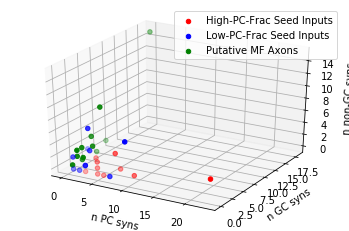

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p3_hpc['n_PC_syns'],p3_hpc['n_GC_syns'],p3_hpc['n_nonGC_syns'],color='r',label='High-PC-Frac Seed Inputs')
ax.scatter(p3_lpc['n_PC_syns'],p3_lpc['n_GC_syns'],p3_lpc['n_nonGC_syns'],color='b',label='Low-PC-Frac Seed Inputs')
ax.scatter(p3_putmf['n_PC_syns'],p3_putmf['n_GC_syns'],p3_putmf['n_nonGC_syns'],color='g',label='Putative MF Axons')

ax.set_xlabel('n PC syns')
ax.set_ylabel('n GC syns')
ax.set_zlabel('n non-GC syns')

plt.legend()

plt.show()

### Plot connectivity based on fractions of synapses

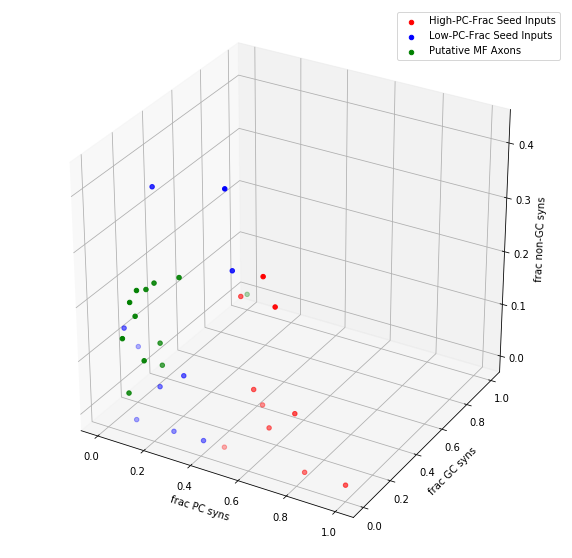

In [9]:
p3_hpc_tot_syns = list(np.sum([list(p3_hpc['n_PC_syns'])] + [list(p3_hpc['n_GC_syns'])] + [list(p3_hpc['n_nonGC_syns'])] + [list(p3_hpc['n_unknown_nonPC_syns'])],axis=0))
p3_lpc_tot_syns = list(np.sum([list(p3_lpc['n_PC_syns'])] + [list(p3_lpc['n_GC_syns'])] + [list(p3_lpc['n_nonGC_syns'])] + [list(p3_lpc['n_unknown_nonPC_syns'])],axis=0))
p3_putmf_tot_syns = list(np.sum([list(p3_putmf['n_PC_syns'])] + [list(p3_putmf['n_GC_syns'])] + [list(p3_putmf['n_nonGC_syns'])] + [list(p3_putmf['n_unknown_nonPC_syns'])],axis=0))

# print(p3_hpc_tot_syns)
# print(p3_lpc_tot_syns)
# print(p3_putmf_tot_syns)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p3_hpc['n_PC_syns']/p3_hpc_tot_syns,p3_hpc['n_GC_syns']/p3_hpc_tot_syns,p3_hpc['n_nonGC_syns']/p3_hpc_tot_syns,color='r',label='High-PC-Frac Seed Inputs')
ax.scatter(p3_lpc['n_PC_syns']/p3_lpc_tot_syns,p3_lpc['n_GC_syns']/p3_lpc_tot_syns,p3_lpc['n_nonGC_syns']/p3_lpc_tot_syns,color='b',label='Low-PC-Frac Seed Inputs')
ax.scatter(p3_putmf['n_PC_syns']/p3_putmf_tot_syns,p3_putmf['n_GC_syns']/p3_putmf_tot_syns,p3_putmf['n_nonGC_syns']/p3_putmf_tot_syns,color='g',label='Putative MF Axons')

ax.set_xlabel('frac PC syns')
ax.set_ylabel('frac GC syns')
ax.set_zlabel('frac non-GC syns')

plt.legend()

plt.show()

***

### Put all axon groups into a single set of feature vectors, with their initial classifications included, and then split the groups into 2 clusters using k-means clustering

In [10]:
n_clust = 2

The k-means clustering algorithm takes a list of feature vectors in a list-of-lists format that is array-like.

Label legend: 0 = high-frac-pc seed input; 1 = low-frac-pc seed input; 2 = putative mf

In [11]:
# Use the fractions of synapses onto each type of target as your features (so that you can compare across axon segments)
p3_obs_ids  = []
p3_labels   = []
p3_features = []
p3_pc_fracs = []
p3_weights  = []

# The feature vector should be constructed by explicitly addressing data frame columns in order to avoid errors due to 
# column reordering.

# Label 0 = high-frac-pc seed inputs
for id in p3_hpc.index:
    obs  = p3_hpc.loc[id]
    ntot = np.sum(list(obs)[1:])
    fp   = obs['n_PC_syns']/ntot
    fg   = obs['n_GC_syns']/ntot
    fn   = obs['n_nonGC_syns']/ntot
    feat_curr = [fp] + [fg] + [fn]
    w    = 1./np.sqrt(ntot)
    
    # Build onto lists of labels and features for all axons
    p3_obs_ids.append(obs[0])
    p3_labels.append(0)
    p3_features.append(feat_curr)
    p3_pc_fracs.append(fp)
    p3_weights.append(w)

# Label 1 = low-frac-pc seed inputs
for id in p3_lpc.index:
    obs  = p3_lpc.loc[id]
    ntot = np.sum(list(obs)[1:])
    fp   = obs['n_PC_syns']/ntot
    fg   = obs['n_GC_syns']/ntot
    fn   = obs['n_nonGC_syns']/ntot
    feat_curr = [fp] + [fg] + [fn]
    w    = 1./np.sqrt(ntot)
    
    p3_obs_ids.append(obs[0])
    p3_labels.append(1)
    p3_features.append(feat_curr)
    p3_pc_fracs.append(fp)
    p3_weights.append(w)

# Class 2 = putative mossy fiber axons
for id in p3_putmf.index:
    obs  = p3_putmf.loc[id]
    ntot = np.sum(list(obs)[1:])
    fp   = obs['n_PC_syns']/ntot
    fg   = obs['n_GC_syns']/ntot
    fn   = obs['n_nonGC_syns']/ntot
    feat_curr = [fp] + [fg] + [fn]
    w    = 1./np.sqrt(ntot)
    
    p3_obs_ids.append(obs[0])
    p3_labels.append(2)
    p3_features.append(feat_curr)
    p3_pc_fracs.append(fp)
    p3_weights.append(w)

In [12]:
# print(p3_obs_ids)
# print(p3_labels)
# print(p3_features)
# print(p3_pc_fracs)
# print(p3_weights)

Consider assigning a weight to each observation in this k-means calcution in a way that is inversely proportional to the uncertainty in each measurement (so in a way that is proportional to the number of observed synapses for a particular axon segment).

In [13]:
seed_curr = 108

if USE_WEIGHTS == 1:
    p3_km_labels = list(KMeans(n_clusters = n_clust, random_state=seed_curr).fit_predict(p3_features, sample_weight=p3_weights))
else:
    p3_km_labels = list(KMeans(n_clusters = n_clust, random_state=seed_curr).fit_predict(p3_features))
# p3_km_labels

***

### For your initial "low-PC-fraction" vs. "high-PC-fraction" threshold (50%), check how many of the axons that are like putative MFs fell into the "low-PC-fraction" group

In [14]:
unique_gt_labels = [0,1,2]
km_group_to_check   = 0 # Either look at group 0 or group 1
frac_axs_in_gtc  = []

for l in unique_gt_labels:
    axons_label_curr   = [i for i,q in enumerate(p3_labels) if q == l]
    n_tot              = len(axons_label_curr)
    km_labels_axs_curr = [p3_km_labels[q] for q in axons_label_curr]
    axons_lc_gtc       = [i for i,q in enumerate(km_labels_axs_curr) if q == km_group_to_check]
    n_gtc              = len(axons_lc_gtc)
    frac_axs_in_gtc.append(n_gtc/n_tot)

***

### An experiment: you have categorized all the seed cell axons as "low-PC-fraction axons" or "high-PC-fraction axons" depending on whether they formed more or fewer than 50% of their synapses onto PCs.

### Now, allow that threshold to vary, and re-assign labels for the seed cell inputs at each threshold. Then look at how many of each type fall into the putative MF group and how many fall into the putative CF-like group.

### The error type we want to avoid is having MF-type axons (which comes from the kmeans group assignment) included in the CF-type group (which comes from your threshold-based label assignment).

In [15]:
thresholds = list(np.arange(0.1,1.0,0.1))

In [16]:
p3_seed_cell_axons = [i for i,q in enumerate(p3_labels) if q != 2] # 2 is the label for putative MFs

p3_km_group_0      = [i for i,q in enumerate(p3_km_labels) if q == 0]
p3_km_group_1      = [i for i,q in enumerate(p3_km_labels) if q == 1]

# print(p3_km_group_0)
# print(p3_km_group_1)

p3_kmg0_frac_l0_by_t = []
p3_kmg0_frac_l1_by_t = []
p3_kmg0_frac_l2_by_t = []

p3_kmg1_frac_l0_by_t = []
p3_kmg1_frac_l1_by_t = []
p3_kmg1_frac_l2_by_t = []

for t in thresholds:
    # Assign labels to the Purkinje seed cell axons based on whether their fraction of PC synapses is below the threshold
    # (label = 1) or above/equal to the threshold (label = 0)
    p3_labels_t_curr = [0]*len(p3_labels)
    
    for ax in range(len(p3_labels_t_curr)):
        if ax in p3_seed_cell_axons:
            if p3_pc_fracs[ax] < t:
                p3_labels_t_curr[ax] = 1
        else:
            p3_labels_t_curr[ax] = 2
    

    # Inspect the makeup of group 0 (store fractions of members with labels 0, 1, and 2)
    p3_group_0_labels_t_curr = [p3_labels_t_curr[q] for q in p3_km_group_0]
    p3_kmg0_frac_l0_by_t.append(len([q for q in p3_group_0_labels_t_curr if q == 0]) / len(p3_group_0_labels_t_curr))
    p3_kmg0_frac_l1_by_t.append(len([q for q in p3_group_0_labels_t_curr if q == 1]) / len(p3_group_0_labels_t_curr))
    p3_kmg0_frac_l2_by_t.append(len([q for q in p3_group_0_labels_t_curr if q == 2]) / len(p3_group_0_labels_t_curr))
    
    # Inspect the makeup of group 1
    p3_group_1_labels_t_curr = [p3_labels_t_curr[q] for q in p3_km_group_1]
    p3_kmg1_frac_l0_by_t.append(len([q for q in p3_group_1_labels_t_curr if q == 0]) / len(p3_group_1_labels_t_curr))
    p3_kmg1_frac_l1_by_t.append(len([q for q in p3_group_1_labels_t_curr if q == 1]) / len(p3_group_1_labels_t_curr))
    p3_kmg1_frac_l2_by_t.append(len([q for q in p3_group_1_labels_t_curr if q == 2]) / len(p3_group_1_labels_t_curr))        

In [17]:
print('\nFractions of G.T. Labels in Group 0, with Increasing Threshold\n')
print('thresh\tgtpct\tltpct\tputmf')
for i in range(len(p3_kmg0_frac_l0_by_t)):
    print('{0:.2}\t{1:.2}\t{2:.2}\t{3:.2}'.format(thresholds[i],p3_kmg0_frac_l0_by_t[i],p3_kmg0_frac_l1_by_t[i],p3_kmg0_frac_l2_by_t[i]))


Fractions of G.T. Labels in Group 0, with Increasing Threshold

thresh	gtpct	ltpct	putmf
0.1	1.0	0.0	0.0
0.2	1.0	0.0	0.0
0.3	0.93	0.067	0.0
0.4	0.87	0.13	0.0
0.5	0.67	0.33	0.0
0.6	0.53	0.47	0.0
0.7	0.27	0.73	0.0
0.8	0.13	0.87	0.0
0.9	0.067	0.93	0.0


In [18]:
print('\nFractions of G.T. Labels in Group 1, with Increasing Threshold\n')
print('thresh\tgthpct\tltpct\tputmf')
for i in range(len(p3_kmg1_frac_l0_by_t)):
    print('{0:.2}\t{1:.2}\t{2:.2}\t{3:.2}'.format(thresholds[i],p3_kmg1_frac_l0_by_t[i],p3_kmg1_frac_l1_by_t[i],p3_kmg1_frac_l2_by_t[i]))


Fractions of G.T. Labels in Group 1, with Increasing Threshold

thresh	gthpct	ltpct	putmf
0.1	0.18	0.12	0.71
0.2	0.059	0.24	0.71
0.3	0.0	0.29	0.71
0.4	0.0	0.29	0.71
0.5	0.0	0.29	0.71
0.6	0.0	0.29	0.71
0.7	0.0	0.29	0.71
0.8	0.0	0.29	0.71
0.9	0.0	0.29	0.71


Plot the makeup of each k-means group as a function of threshold

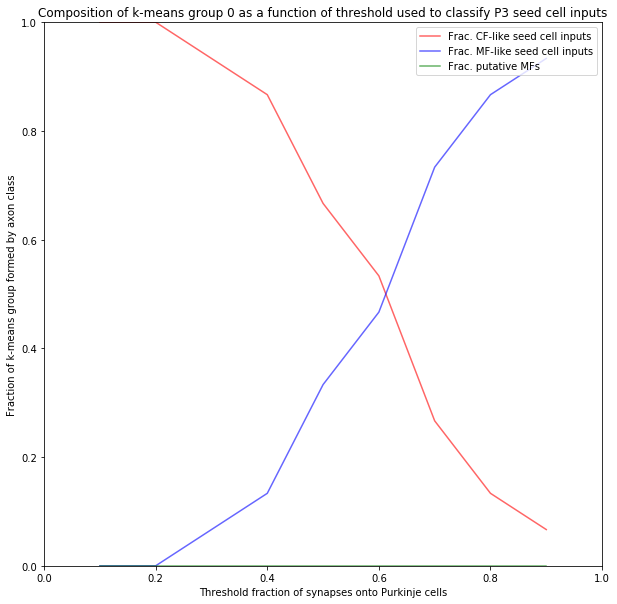

In [19]:
# k-means group 0
plt.figure(figsize=(10,10))
plt.plot(thresholds,p3_kmg0_frac_l0_by_t,color='r',alpha=0.6,label='Frac. CF-like seed cell inputs')
plt.plot(thresholds,p3_kmg0_frac_l1_by_t,color='b',alpha=0.6,label='Frac. MF-like seed cell inputs')
plt.plot(thresholds,p3_kmg0_frac_l2_by_t,color='g',alpha=0.6,label='Frac. putative MFs')
plt.xlabel('Threshold fraction of synapses onto Purkinje cells')
plt.ylabel('Fraction of k-means group formed by axon class')
plt.title('Composition of k-means group 0 as a function of threshold used to classify P3 seed cell inputs')
plt.legend(loc='upper right')
plt.axis([0,1,0,1])
plt.show()

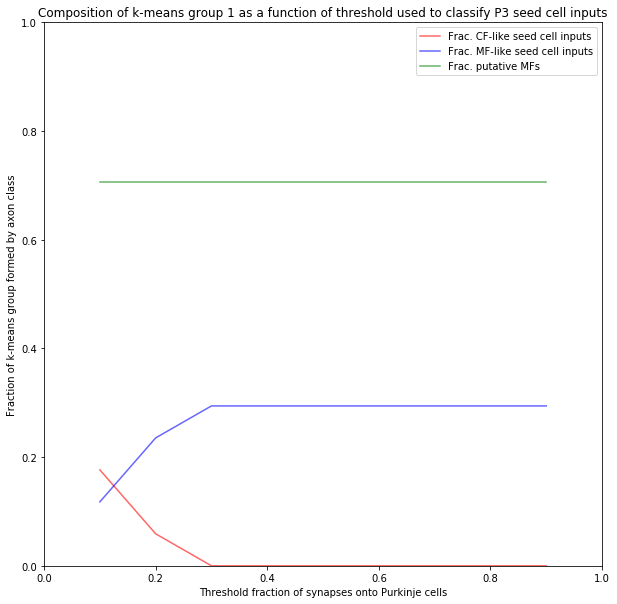

In [20]:
# k-means group 1
plt.figure(figsize=(10,10))
plt.plot(thresholds,p3_kmg1_frac_l0_by_t,color='r',alpha=0.6,label='Frac. CF-like seed cell inputs')
plt.plot(thresholds,p3_kmg1_frac_l1_by_t,color='b',alpha=0.6,label='Frac. MF-like seed cell inputs')
plt.plot(thresholds,p3_kmg1_frac_l2_by_t,color='g',alpha=0.6,label='Frac. putative MFs')
plt.xlabel('Threshold fraction of synapses onto Purkinje cells')
plt.ylabel('Fraction of k-means group formed by axon class')
plt.title('Composition of k-means group 1 as a function of threshold used to classify P3 seed cell inputs')
plt.legend(loc='upper right')
plt.axis([0,1,0,1])
plt.show()

Plot the two k-means-defined clusters in the single dimension describing fractions of synapses onto Purkinje cells to see how they overlap

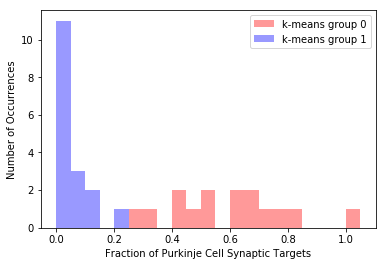

In [21]:
p3_group0_locs = [i for i,q in enumerate(p3_km_labels) if q==0]
p3_group1_locs = [i for i,q in enumerate(p3_km_labels) if q==1]

p3_group0_pc_fracs = [p3_pc_fracs[i] for i in p3_group0_locs]
p3_group1_pc_fracs = [p3_pc_fracs[i] for i in p3_group1_locs]

# You can re-calculate an appropriate bin size by using the maximum total
# number of synapses between an axon segment and all of its targets to see what the
# order of magnitude of the minimum synapse fraction will be.
# hist_bin_edges = 0.01 * np.arange(-5,105,10).astype(float)
hist_bin_edges = 0.01 * np.arange(0,110,5).astype(float)

plt.figure()
plt.hist(p3_group0_pc_fracs,bins=hist_bin_edges,color='r',alpha=0.4,label='k-means group 0')
plt.hist(p3_group1_pc_fracs,bins=hist_bin_edges,color='b',alpha=0.4,label='k-means group 1')
plt.xlabel('Fraction of Purkinje Cell Synaptic Targets')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.show()

***

***

### Run the k-means clustering multiple times, and see how the assigned labels (i.e. the members of each group) vary across iterations. Also find the range of fract_PC values that separate the two k-means groups)

In [22]:
def k_means_threshold(seed_list,gt_ids,gt_labels,features,weights=[],TO_USE_WEIGHTS=0):
    # seed_list: List type. Has seeds used to initialize rng for k-means. Length determines number of k-means runs
    # gt_labels: List type. Ground truth labels for each of the observations.
    # features:  List of lists. Each list has the structure [frac_pc_syns,frac_gc_syns,frac_other_syns]
    # weights:   List type. Contains weights for the observations to be clustered. Length must equal number of obs-
    #            ervations in order for weights to be applied.
    # TO_USE_WEIGHTS: Boolean scalar. Value of 1 activates the weighting of observations according to input.
    if len(seed_list) > 0:
        g1_mins = []
        g1_maxs = []
        g2_mins = []
        g2_maxs = []
        
        g1_ids = []
        g2_ids = []
        
        g1_labels = []
        g2_labels = []
        
        for seed_curr in seed_list:
            # We are always trying to split axons into 2 groups
            if TO_USE_WEIGHTS == 1:
                    if len(weights) == len(gt_labels):
                        kmeans = KMeans(n_clusters = 2, random_state=seed_curr).fit(features,sample_weight=weights)
                    else:
                        print('Error: weight vectors are bad.')
                        return
            else:
                kmeans = KMeans(n_clusters = 2, random_state=seed_curr).fit(features)
            km_labels = list(kmeans.labels_)
            
            # This next part is sort of hard-coded, but you know that the k-means algorithm
            # will return labels of 0 and 1 because there will be two groups
            group1_locs = [i for i,q in enumerate(km_labels) if q==0]
            group2_locs = [i for i,q in enumerate(km_labels) if q==1]
            
            group1_pc_fracs = [features[i][0] for i in group1_locs]
            group2_pc_fracs = [features[i][0] for i in group2_locs]
            
            group1_ids = [gt_ids[i] for i in group1_locs]
            group2_ids = [gt_ids[i] for i in group2_locs]
            
            group1_gt_labels = [gt_labels[i] for i in group1_locs]
            group2_gt_labels = [gt_labels[i] for i in group2_locs]
            
            # Start with the ranges for group 1 and group 2
            g1_min = np.min(group1_pc_fracs)
            g1_max = np.max(group1_pc_fracs)
            g2_min = np.min(group2_pc_fracs)
            g2_max = np.max(group2_pc_fracs)
            
            g1_mins.append(g1_min)
            g1_maxs.append(g1_max)
            g2_mins.append(g2_min)
            g2_maxs.append(g2_max)
            
            g1_ids.append(group1_ids)
            g2_ids.append(group2_ids)
            
            g1_labels.append(group1_gt_labels)
            g2_labels.append(group2_gt_labels)
            
    else:
        print('No list of seeds provided.')
        return
    
    return(g1_mins,g1_maxs,g2_mins,g2_maxs,g1_ids,g2_ids,g1_labels,g2_labels)
        

Run k-means multiple times to figure out 1) how much the members of the two groups change and 2) to find a distribution of Purkinje cell fractions that separate the two groups each time

In [23]:
p3_km_seeds = np.arange(0,20)
p3_g1_mins, p3_g1_maxs, p3_g2_mins, p3_g2_maxs, p3_g1_ids, p3_g2_ids, p3_g1_labels, p3_g2_labels = k_means_threshold(p3_km_seeds,p3_obs_ids,p3_labels,p3_features)

In [24]:
print('g1_min\tg1_max\tg2_min\tg2_max')
for i in range(len(p3_km_seeds)):
    print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'.format(p3_g1_mins[i],p3_g1_maxs[i],p3_g2_mins[i],p3_g2_maxs[i]))

g1_min	g1_max	g2_min	g2_max
0.000	0.286	0.333	1.000
0.333	1.000	0.000	0.286
0.333	1.000	0.000	0.286
0.000	0.286	0.333	1.000
0.333	1.000	0.000	0.286
0.333	1.000	0.000	0.286
0.000	0.286	0.333	1.000
0.000	0.286	0.333	1.000
0.333	1.000	0.000	0.286
0.000	0.286	0.333	1.000
0.333	1.000	0.000	0.286
0.000	0.286	0.333	1.000
0.333	1.000	0.000	0.286
0.000	0.286	0.333	1.000
0.000	0.286	0.333	1.000
0.333	1.000	0.000	0.286
0.333	1.000	0.000	0.286
0.000	0.286	0.333	1.000
0.000	0.286	0.333	1.000
0.000	0.286	0.333	1.000


Find the range of PC fractions in each case that separate the group with fewer PC synaptic targets from the group with more PC synaptic targets.

In [25]:
p3_min_PC_sep_range = []
p3_max_PC_sep_range = []
for i in range(len(p3_km_seeds)):
    if p3_g1_maxs[i] < p3_g2_mins[i]:
        p3_min_PC_sep_range.append(p3_g1_maxs[i])
        p3_max_PC_sep_range.append(p3_g2_mins[i])
    elif p3_g2_maxs[i] < p3_g1_mins[i]:
        p3_min_PC_sep_range.append(p3_g2_maxs[i])
        p3_max_PC_sep_range.append(p3_g1_mins[i])
    else:
        print('The frac_PC values of the two k-means groups in iteration {0} have overlapping distributions.'.format(i))
        p3_min_PC_sep_range.append(-1)
        p3_max_PC_sep_range.append(-1)

Plot the ranges

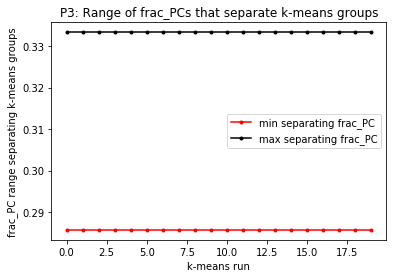

In [26]:
plt.figure()
plt.plot(np.arange(len(p3_km_seeds)),p3_min_PC_sep_range,color='r',label='min separating frac_PC',marker='.')
plt.plot(np.arange(len(p3_km_seeds)),p3_max_PC_sep_range,color='k',label='max separating frac_PC',marker='.')
plt.xlabel('k-means run')
plt.ylabel('frac_PC range separating k-means groups')
plt.title('P3: Range of frac_PCs that separate k-means groups')
plt.legend()
plt.show()

Another way of checking the number of groupings: check the number of unique ID lists between group 1 and group 2 combined

In [27]:
p3_all_id_groups = p3_g1_ids + p3_g2_ids
p3_u_groups = []
for list_curr in p3_all_id_groups:
    if list_curr not in p3_u_groups:
        p3_u_groups.append(list_curr) 
print(len(p3_u_groups))

2


Summary: k-means partitions the axon segments into the same clusters every time it is run, even with different seeds to initialize the process.

***

Visualization: plot the populations of axons in frac GCs vs. frac PCs space with a partition from above

In [28]:
type(list(p3_hpc['n_PC_syns']/p3_hpc_tot_syns))

list

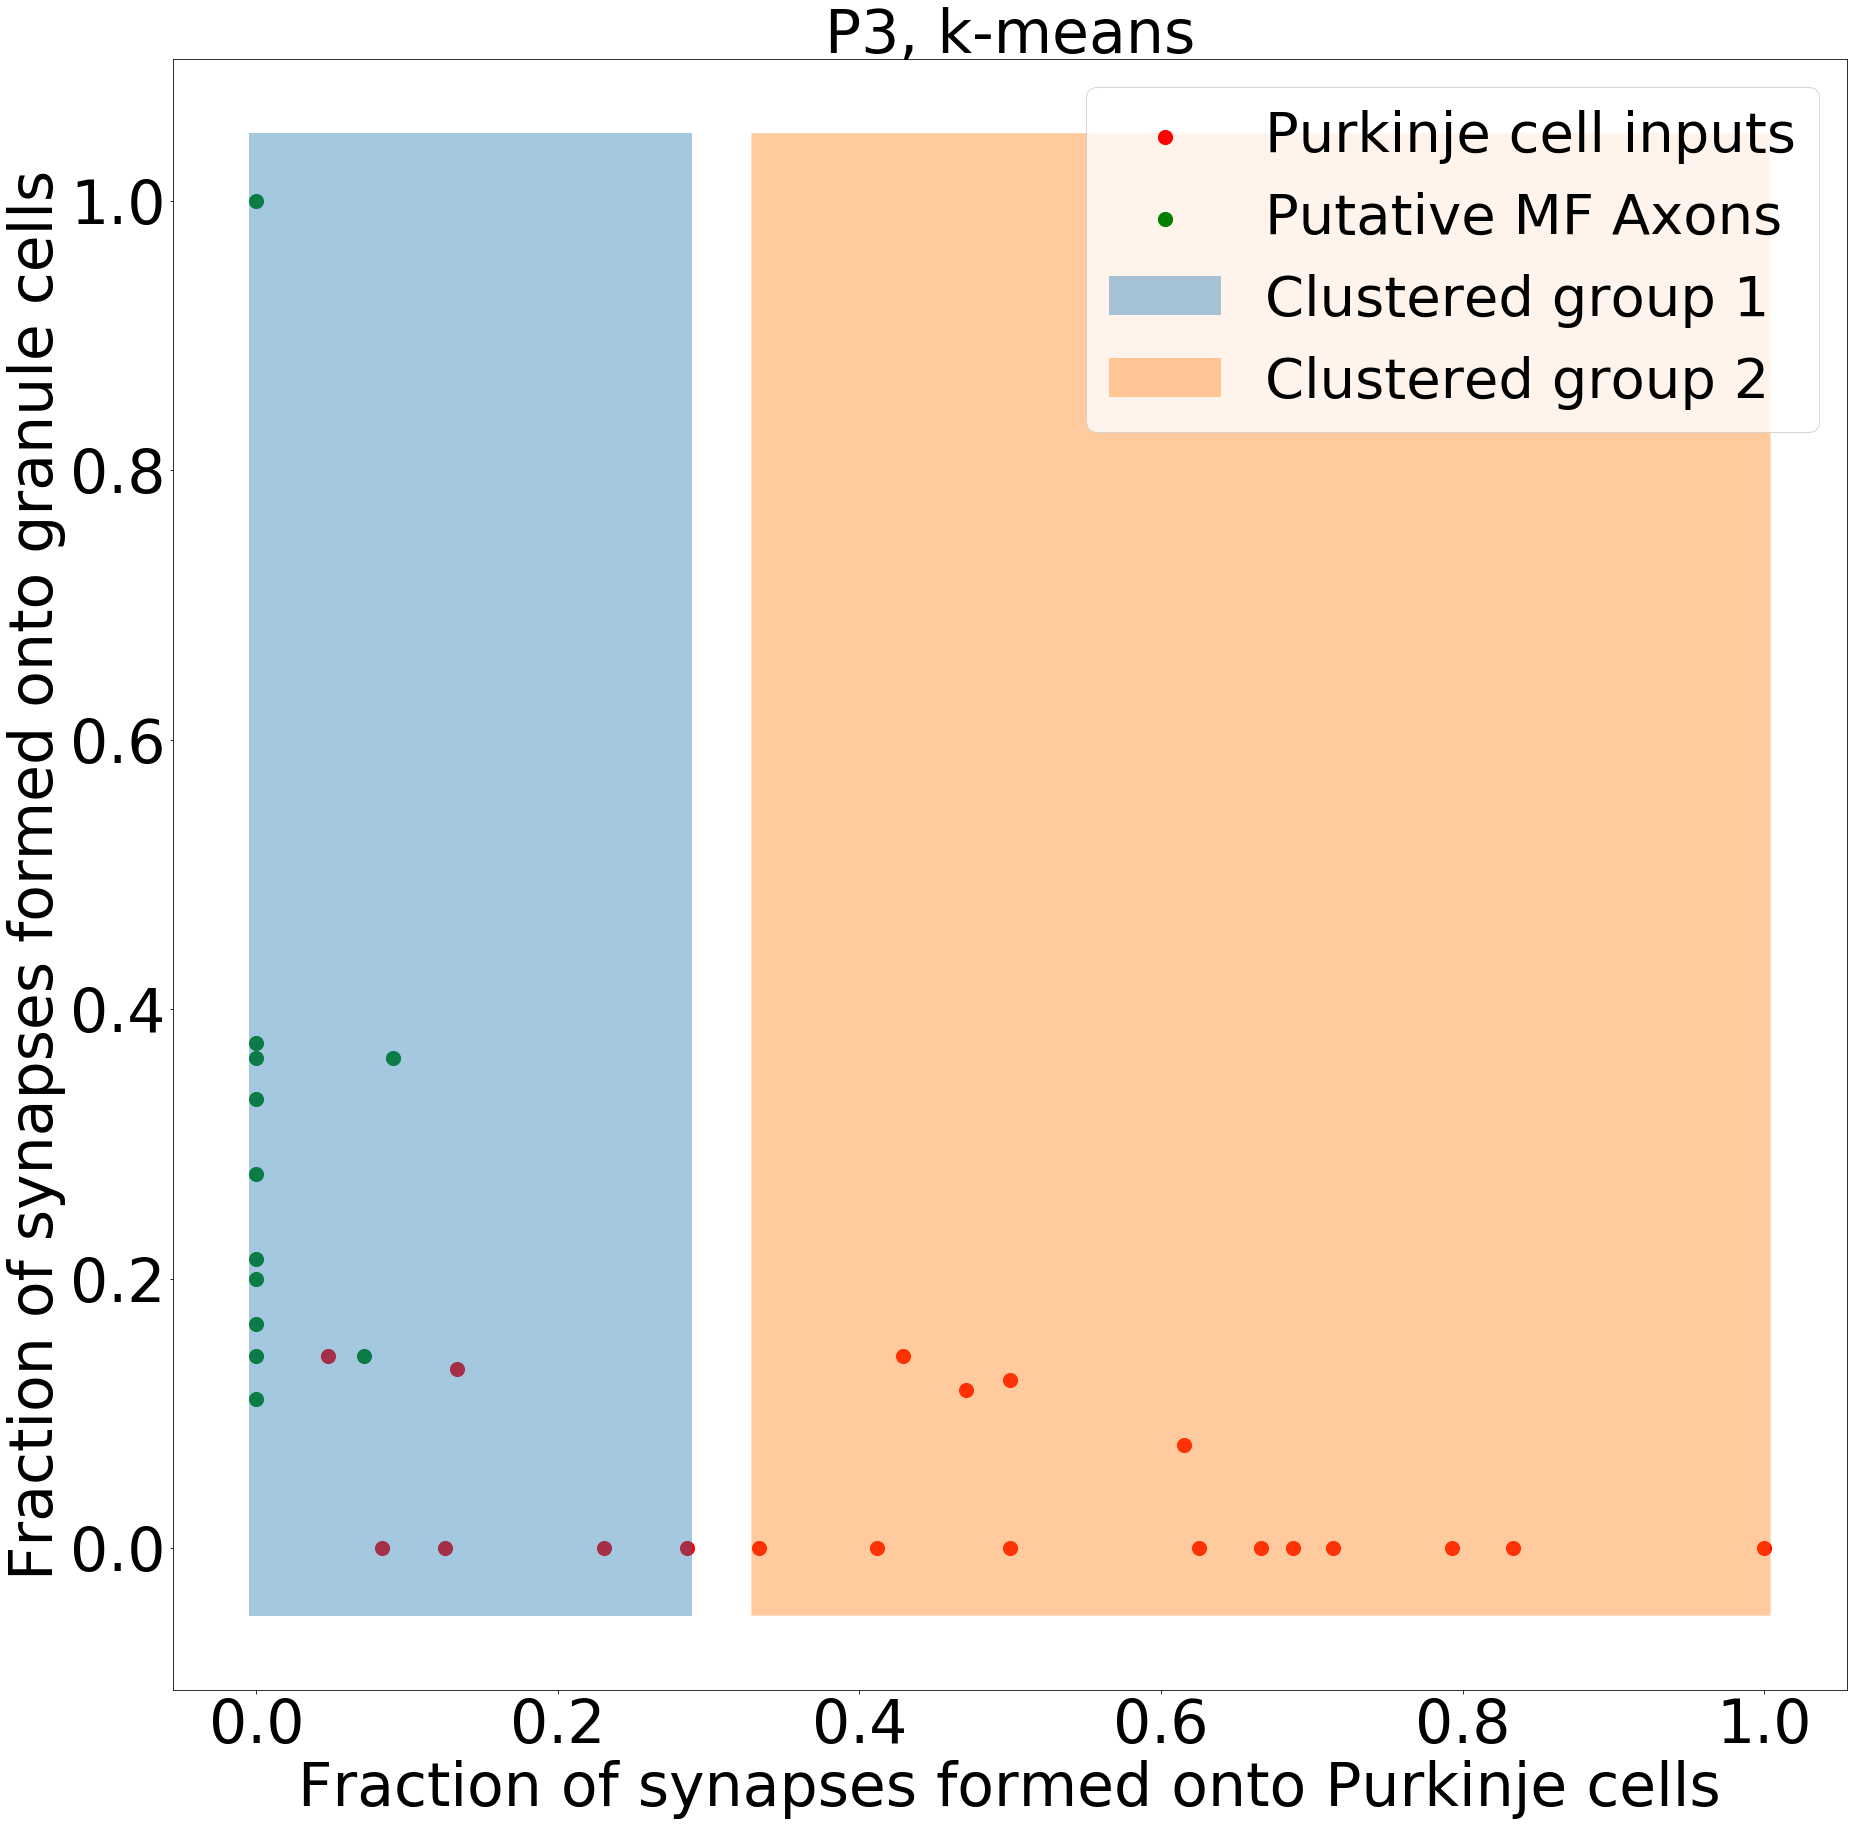

In [29]:
# p3, k-means partitioning
p3_km_ll = np.min(list(set(p3_min_PC_sep_range)))
p3_km_ul = np.max(list(set(p3_max_PC_sep_range)))

plt.figure(figsize=(30,30))
all_pc_input_pc_fracs = list(p3_hpc['n_PC_syns']/p3_hpc_tot_syns) + list(p3_lpc['n_PC_syns']/p3_lpc_tot_syns)
all_pc_input_gc_fracs = list(p3_hpc['n_GC_syns']/p3_hpc_tot_syns) + list(p3_lpc['n_GC_syns']/p3_lpc_tot_syns)
plt.scatter(all_pc_input_pc_fracs,all_pc_input_gc_fracs,s=MS,color='r',label='Purkinje cell inputs')
# plt.scatter(p3_hpc['n_PC_syns']/p3_hpc_tot_syns,p3_hpc['n_GC_syns']/p3_hpc_tot_syns,color='r',s=100,label='High-PC-Frac Seed Inputs')
# plt.scatter(p3_lpc['n_PC_syns']/p3_lpc_tot_syns,p3_lpc['n_GC_syns']/p3_lpc_tot_syns,color='b',s=100,label='Low-PC-Frac Seed Inputs')
plt.scatter(p3_putmf['n_PC_syns']/p3_putmf_tot_syns,p3_putmf['n_GC_syns']/p3_putmf_tot_syns,color='g',s=MS,label='Putative MF Axons')
xs_region1 = np.arange(-5,int(p3_km_ll*1000+5))*0.001
y1sr1 = np.zeros((xs_region1.shape[0]))-0.05
y2sr1 = y1sr1 + 1.1
xs_region2 = np.arange(p3_km_ul*1000-5,1005)*0.001
y1sr2 = np.zeros((xs_region2.shape[0]))-0.05
y2sr2 = y1sr2 + 1.1
plt.fill_between(xs_region1,y1sr1,y2sr1,alpha=0.4,label='Clustered group 1')
plt.fill_between(xs_region2,y1sr2,y2sr2,alpha=0.4,label='Clustered group 2')
plt.xlabel('Fraction of synapses formed onto Purkinje cells',fontsize=FS)
plt.ylabel('Fraction of synapses formed onto granule cells',fontsize=FS)
plt.title('P3, k-means',fontsize=FS)
plt.tick_params(labelsize=FS)
plt.legend(loc='best',fontsize=FS-4)
p3_km_fname = './data/figures/p3_p7_cf_mf_clustering/190218_p3_kmeans_clustering.png'
# plt.show()
plt.savefig(p3_km_fname)

***

***

### Construct connectivity data for P7

In [76]:
p7_hpc_ax_ids = [40,32,55,49,61,24,15,21,10,67]
p7_hpc_n_pcs = [18,12,14,27,29,21,20,30,5,47]
p7_hpc_n_gcs = [0,2,0,1,1,0,0,5,1,1]
p7_hpc_n_nonGCs = [1,4,0,4,1,0,1,4,1,4]
p7_hpc_n_unknown_nonPCs = [1,1,1,0,3,1,2,4,1,11]
    
p7_hpc = pd.DataFrame({'axon_id':p7_hpc_ax_ids,'n_PC_syns':p7_hpc_n_pcs,'n_GC_syns':p7_hpc_n_gcs,'n_nonGC_syns':p7_hpc_n_nonGCs,'n_unknown_nonPC_syns':p7_hpc_n_unknown_nonPCs})
p7_hpc.head()

,axon_id,n_PC_syns,n_GC_syns,n_nonGC_syns,n_unknown_nonPC_syns
0,40,18,0,1,1
1,32,12,2,4,1
2,55,14,0,0,1
3,49,27,1,4,0
4,61,29,1,1,3


In [78]:
p7_lpc_ax_ids = [25,26,35,53]
p7_lpc_n_pcs = [1,2,1,3]
p7_lpc_n_gcs = [3,2,0,8]
p7_lpc_n_nonGCs = [0,0,3,3]
p7_lpc_n_unknown_nonPCs = [1,1,4,4]

p7_lpc = pd.DataFrame({'axon_id':p7_lpc_ax_ids,'n_PC_syns':p7_lpc_n_pcs,'n_GC_syns':p7_lpc_n_gcs,'n_nonGC_syns':p7_lpc_n_nonGCs,'n_unknown_nonPC_syns':p7_lpc_n_unknown_nonPCs})
p7_lpc.head()

,axon_id,n_PC_syns,n_GC_syns,n_nonGC_syns,n_unknown_nonPC_syns
0,25,1,3,0,1
1,26,2,2,0,1
2,35,1,0,3,4
3,53,3,8,3,4


In [79]:
p7_putmf_ax_ids = [71,72,73,75,591,311,361,371,381,431]
p7_putmf_n_pcs = [3,0,0,0,0,0,0,0,0,0]
p7_putmf_n_gcs = [9,7,2,6,8,23,5,8,16,14]
p7_putmf_n_nonGCs = [4,7,1,8,3,1,7,3,1,2]
p7_putmf_n_unknown_nonPCs = [3,5,2,4,7,1,4,8,14,8]

p7_putmf = pd.DataFrame({'axon_id':p7_putmf_ax_ids,'n_PC_syns':p7_putmf_n_pcs,'n_GC_syns':p7_putmf_n_gcs,'n_nonGC_syns':p7_putmf_n_nonGCs,'n_unknown_nonPC_syns':p7_putmf_n_unknown_nonPCs})
p7_putmf

,axon_id,n_PC_syns,n_GC_syns,n_nonGC_syns,n_unknown_nonPC_syns
0,71,3,9,4,3
1,72,0,7,7,5
2,73,0,2,1,2
3,75,0,6,8,4
4,591,0,8,3,7
5,311,0,23,1,1
6,361,0,5,7,4
7,371,0,8,3,8
8,381,0,16,1,14
9,431,0,14,2,8


### Plot data based on numbers of synapses and fractions of synapses (where the denominator INCLUDES the unidentified, non-PC targets)

### Numbers of synapses

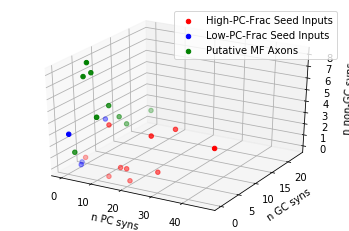

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p7_hpc['n_PC_syns'],p7_hpc['n_GC_syns'],p7_hpc['n_nonGC_syns'],color='r',label='High-PC-Frac Seed Inputs')
ax.scatter(p7_lpc['n_PC_syns'],p7_lpc['n_GC_syns'],p7_lpc['n_nonGC_syns'],color='b',label='Low-PC-Frac Seed Inputs')
ax.scatter(p7_putmf['n_PC_syns'],p7_putmf['n_GC_syns'],p7_putmf['n_nonGC_syns'],color='g',label='Putative MF Axons')

ax.set_xlabel('n PC syns')
ax.set_ylabel('n GC syns')
ax.set_zlabel('n non-GC syns')

plt.legend()

plt.show()

### Fractions of synapses

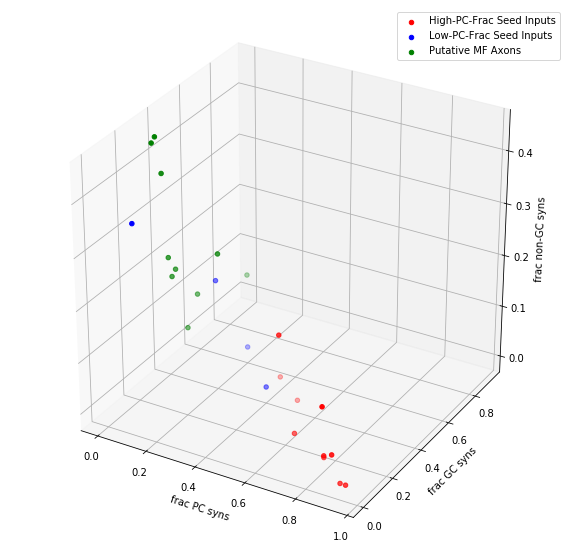

In [34]:
p7_hpc_tot_syns = list(np.sum([list(p7_hpc['n_PC_syns'])] + [list(p7_hpc['n_GC_syns'])] + [list(p7_hpc['n_nonGC_syns'])] + [list(p7_hpc['n_unknown_nonPC_syns'])],axis=0))
p7_lpc_tot_syns = list(np.sum([list(p7_lpc['n_PC_syns'])] + [list(p7_lpc['n_GC_syns'])] + [list(p7_lpc['n_nonGC_syns'])] + [list(p7_lpc['n_unknown_nonPC_syns'])],axis=0))
p7_putmf_tot_syns = list(np.sum([list(p7_putmf['n_PC_syns'])] + [list(p7_putmf['n_GC_syns'])] + [list(p7_putmf['n_nonGC_syns'])] + [list(p7_putmf['n_unknown_nonPC_syns'])],axis=0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p7_hpc['n_PC_syns']/p7_hpc_tot_syns,p7_hpc['n_GC_syns']/p7_hpc_tot_syns,p7_hpc['n_nonGC_syns']/p7_hpc_tot_syns,color='r',label='High-PC-Frac Seed Inputs')
ax.scatter(p7_lpc['n_PC_syns']/p7_lpc_tot_syns,p7_lpc['n_GC_syns']/p7_lpc_tot_syns,p7_lpc['n_nonGC_syns']/p7_lpc_tot_syns,color='b',label='Low-PC-Frac Seed Inputs')
ax.scatter(p7_putmf['n_PC_syns']/p7_putmf_tot_syns,p7_putmf['n_GC_syns']/p7_putmf_tot_syns,p7_putmf['n_nonGC_syns']/p7_putmf_tot_syns,color='g',label='Putative MF Axons')

ax.set_xlabel('frac PC syns')
ax.set_ylabel('frac GC syns')
ax.set_zlabel('frac non-GC syns')

plt.legend()

plt.show()

***

### Run k-means clustering with n = 2 clusters

Label legend: 0 = high-frac-pc seed input; 1 = low-frac-pc seed input; 2 = putative mf

In [35]:
# Use the fractions of synapses onto each type of target as your features (so that you can compare across axon segments)
p7_obs_ids  = []
p7_labels   = []
p7_features = []
p7_pc_fracs = []
p7_weights  = []

# The feature vector should be constructed by explicitly addressing data frame columns in order to avoid errors due to 
# column reordering.

# Label 0 = high-frac-pc seed inputs
for id in p7_hpc.index:
    obs  = p7_hpc.loc[id]
    ntot = np.sum(list(obs)[1:])
    fp   = obs['n_PC_syns']/ntot
    fg   = obs['n_GC_syns']/ntot
    fn   = obs['n_nonGC_syns']/ntot
    feat_curr = [fp] + [fg] + [fn]
    w    = 1./np.sqrt(ntot)
    
    # Build onto lists of labels and features for all axons
    p7_obs_ids.append(obs[0])
    p7_labels.append(0)
    p7_features.append(feat_curr)
    p7_pc_fracs.append(fp)
    p7_weights.append(w)

# Label 1 = low-frac-pc seed inputs
for id in p7_lpc.index:
    obs  = p7_lpc.loc[id]
    ntot = np.sum(list(obs)[1:])
    fp   = obs['n_PC_syns']/ntot
    fg   = obs['n_GC_syns']/ntot
    fn   = obs['n_nonGC_syns']/ntot
    feat_curr = [fp] + [fg] + [fn]
    w    = 1./np.sqrt(ntot)
    
    p7_obs_ids.append(obs[0])
    p7_labels.append(1)
    p7_features.append(feat_curr)
    p7_pc_fracs.append(fp)
    p7_weights.append(w)

# Class 2 = putative mossy fiber axons
for id in p7_putmf.index:
    obs  = p7_putmf.loc[id]
    ntot = np.sum(list(obs)[1:])
    fp   = obs['n_PC_syns']/ntot
    fg   = obs['n_GC_syns']/ntot
    fn   = obs['n_nonGC_syns']/ntot
    feat_curr = [fp] + [fg] + [fn]
    w    = 1./np.sqrt(ntot)
    
    p7_obs_ids.append(obs[0])
    p7_labels.append(2)
    p7_features.append(feat_curr)
    p7_pc_fracs.append(fp)
    p7_weights.append(w)

In [36]:
# print(p7_obs_ids)
# print(p7_labels)
# print(p7_features)
# print(p7_pc_fracs)
# print(p7_weights)

In [37]:
seed_curr = 109 # Just use a different random seed than you used above

if USE_WEIGHTS == 1:
    p7_km_labels = list(KMeans(n_clusters = n_clust, random_state=seed_curr).fit_predict(p7_features, sample_weight=p7_weights))
else:
    p7_km_labels = list(KMeans(n_clusters = n_clust, random_state=seed_curr).fit_predict(p7_features))
# p7_km_labels

### As for P3, vary the threshold for calling a P7 seed cell input either "low-PC-fraction" slash "MF-like" or "high-PC-fraction" slash "CF-like", and see how the composition of each of the k-means groups changes

In [38]:
p7_seed_cell_axons = [i for i,q in enumerate(p7_labels) if q != 2] # 2 is the label for putative MFs

p7_km_group_0      = [i for i,q in enumerate(p7_km_labels) if q == 0]
p7_km_group_1      = [i for i,q in enumerate(p7_km_labels) if q == 1]

# print(p7_km_group_0)
# print(p7_km_group_1)

p7_kmg0_frac_l0_by_t = []
p7_kmg0_frac_l1_by_t = []
p7_kmg0_frac_l2_by_t = []

p7_kmg1_frac_l0_by_t = []
p7_kmg1_frac_l1_by_t = []
p7_kmg1_frac_l2_by_t = []

for t in thresholds:
    # Assign labels to the Purkinje seed cell axons based on whether their fraction of PC synapses is below the threshold
    # (label = 1) or above/equal to the threshold (label = 0)
    p7_labels_t_curr = [0]*len(p7_labels)
    
    for ax in range(len(p7_labels_t_curr)):
        if ax in p7_seed_cell_axons:
            if p7_pc_fracs[ax] < t:
                p7_labels_t_curr[ax] = 1
        else:
            p7_labels_t_curr[ax] = 2
    

    # Inspect the makeup of group 0 (store fractions of members with labels 0, 1, and 2)
    p7_group_0_labels_t_curr = [p7_labels_t_curr[q] for q in p7_km_group_0]
    p7_kmg0_frac_l0_by_t.append(len([q for q in p7_group_0_labels_t_curr if q == 0]) / len(p7_group_0_labels_t_curr))
    p7_kmg0_frac_l1_by_t.append(len([q for q in p7_group_0_labels_t_curr if q == 1]) / len(p7_group_0_labels_t_curr))
    p7_kmg0_frac_l2_by_t.append(len([q for q in p7_group_0_labels_t_curr if q == 2]) / len(p7_group_0_labels_t_curr))
    
    # Inspect the makeup of group 1
    p7_group_1_labels_t_curr = [p7_labels_t_curr[q] for q in p7_km_group_1]
    p7_kmg1_frac_l0_by_t.append(len([q for q in p7_group_1_labels_t_curr if q == 0]) / len(p7_group_1_labels_t_curr))
    p7_kmg1_frac_l1_by_t.append(len([q for q in p7_group_1_labels_t_curr if q == 1]) / len(p7_group_1_labels_t_curr))
    p7_kmg1_frac_l2_by_t.append(len([q for q in p7_group_1_labels_t_curr if q == 2]) / len(p7_group_1_labels_t_curr))        

In [39]:
print('\nFractions of G.T. Labels in Group 0, with Increasing Threshold\n')
print('thresh\thpc\tlpc\tputmf')
for i in range(len(p7_kmg0_frac_l0_by_t)):
    print('{0:.2}\t{1:.2}\t{2:.2}\t{3:.2}'.format(thresholds[i],p7_kmg0_frac_l0_by_t[i],p7_kmg0_frac_l1_by_t[i],p7_kmg0_frac_l2_by_t[i]))


Fractions of G.T. Labels in Group 0, with Increasing Threshold

thresh	hpc	lpc	putmf
0.1	1.0	0.0	0.0
0.2	1.0	0.0	0.0
0.3	1.0	0.0	0.0
0.4	1.0	0.0	0.0
0.5	1.0	0.0	0.0
0.6	1.0	0.0	0.0
0.7	0.7	0.3	0.0
0.8	0.6	0.4	0.0
0.9	0.3	0.7	0.0


In [40]:
print('\nFractions of G.T. Labels in Group 1, with Increasing Threshold\n')
print('thresh\thpc\tlpc\tputmf')
for i in range(len(p7_kmg1_frac_l0_by_t)):
    print('{0:.2}\t{1:.2}\t{2:.2}\t{3:.2}'.format(thresholds[i],p7_kmg1_frac_l0_by_t[i],p7_kmg1_frac_l1_by_t[i],p7_kmg1_frac_l2_by_t[i]))


Fractions of G.T. Labels in Group 1, with Increasing Threshold

thresh	hpc	lpc	putmf
0.1	0.29	0.0	0.71
0.2	0.14	0.14	0.71
0.3	0.071	0.21	0.71
0.4	0.071	0.21	0.71
0.5	0.0	0.29	0.71
0.6	0.0	0.29	0.71
0.7	0.0	0.29	0.71
0.8	0.0	0.29	0.71
0.9	0.0	0.29	0.71


Plot the composition of each k-means group as a function of threshold

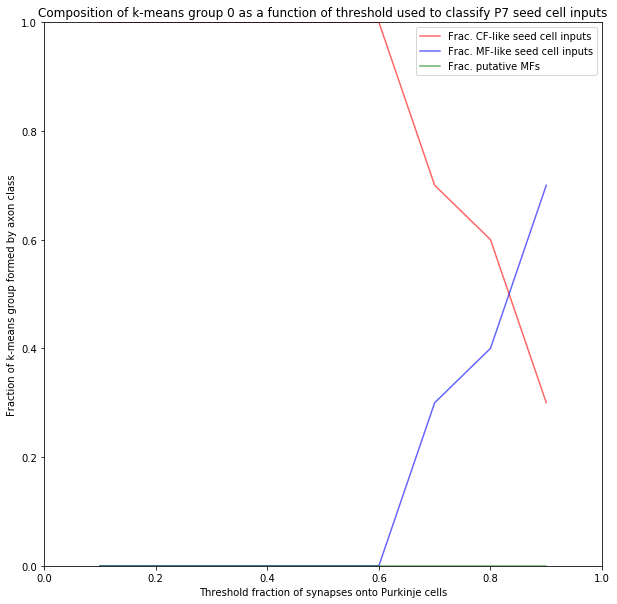

In [41]:
# k-means group 0
plt.figure(figsize=(10,10))
plt.plot(thresholds,p7_kmg0_frac_l0_by_t,color='r',alpha=0.6,label='Frac. CF-like seed cell inputs')
plt.plot(thresholds,p7_kmg0_frac_l1_by_t,color='b',alpha=0.6,label='Frac. MF-like seed cell inputs')
plt.plot(thresholds,p7_kmg0_frac_l2_by_t,color='g',alpha=0.6,label='Frac. putative MFs')
plt.xlabel('Threshold fraction of synapses onto Purkinje cells')
plt.ylabel('Fraction of k-means group formed by axon class')
plt.title('Composition of k-means group 0 as a function of threshold used to classify P7 seed cell inputs')
plt.legend(loc='upper right')
plt.axis([0,1,0,1])
plt.show()

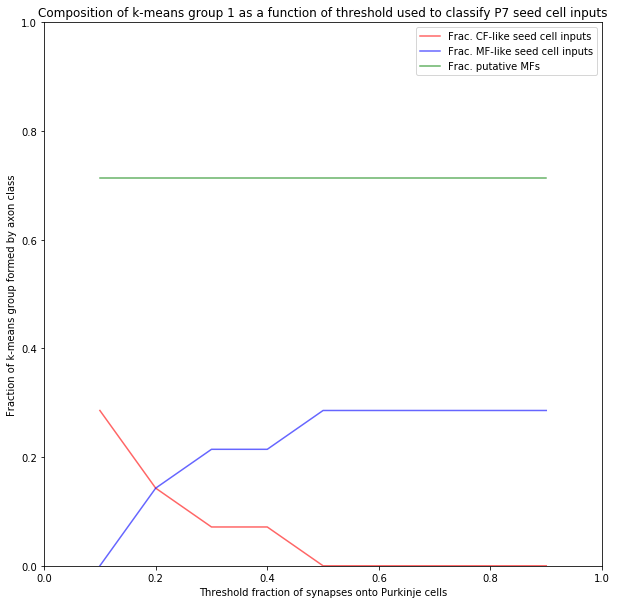

In [42]:
# k-means group 1
plt.figure(figsize=(10,10))
plt.plot(thresholds,p7_kmg1_frac_l0_by_t,color='r',alpha=0.6,label='Frac. CF-like seed cell inputs')
plt.plot(thresholds,p7_kmg1_frac_l1_by_t,color='b',alpha=0.6,label='Frac. MF-like seed cell inputs')
plt.plot(thresholds,p7_kmg1_frac_l2_by_t,color='g',alpha=0.6,label='Frac. putative MFs')
plt.xlabel('Threshold fraction of synapses onto Purkinje cells')
plt.ylabel('Fraction of k-means group formed by axon class')
plt.title('Composition of k-means group 1 as a function of threshold used to classify P7 seed cell inputs')
plt.legend(loc='upper right')
plt.axis([0,1,0,1])
plt.show()

Plot the two k-means-defined clusters in the single dimension describing fractions of synapses onto Purkinje cells to see how they overlap

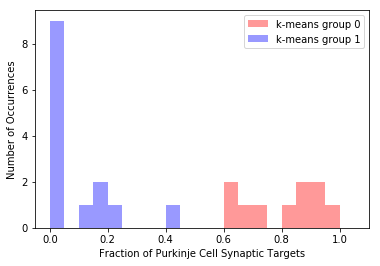

In [43]:
p7_group0_locs = [i for i,q in enumerate(p7_km_labels) if q==0]
p7_group1_locs = [i for i,q in enumerate(p7_km_labels) if q==1]

p7_group0_pc_fracs = [p7_pc_fracs[i] for i in p7_group0_locs]
p7_group1_pc_fracs = [p7_pc_fracs[i] for i in p7_group1_locs]

# You can re-calculate an appropriate bin size by using the maximum total
# number of synapses between an axon segment and all of its targets to see what the
# order of magnitude of the minimum synapse fraction will be.
# hist_bin_edges = 0.01 * np.arange(-5,105,10).astype(float)
hist_bin_edges = 0.01 * np.arange(0,110,5).astype(float)

plt.figure()
plt.hist(p7_group0_pc_fracs,bins=hist_bin_edges,color='r',alpha=0.4,label='k-means group 0')
plt.hist(p7_group1_pc_fracs,bins=hist_bin_edges,color='b',alpha=0.4,label='k-means group 1')
plt.xlabel('Fraction of Purkinje Cell Synaptic Targets')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.show()

***

***

### Now run k-means multiple ways to figure out by how much the grouping of axons into the two groups and the range of frac_PC values that split the two groups change

In [44]:
p7_km_seeds = np.arange(11,31)
p7_g1_mins, p7_g1_maxs, p7_g2_mins, p7_g2_maxs, p7_g1_ids, p7_g2_ids, p7_g1_labels, p7_g2_labels = k_means_threshold(p7_km_seeds,p7_obs_ids,p7_labels,p7_features)

In [45]:
print('g1_min\tg1_max\tg2_min\tg2_max')
for i in range(len(p7_km_seeds)):
    print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'.format(p7_g1_mins[i],p7_g1_maxs[i],p7_g2_mins[i],p7_g2_maxs[i]))

g1_min	g1_max	g2_min	g2_max
0.000	0.400	0.625	0.955
0.000	0.400	0.625	0.955
0.000	0.400	0.625	0.955
0.625	0.955	0.000	0.400
0.625	0.955	0.000	0.400
0.625	0.955	0.000	0.400
0.000	0.400	0.625	0.955
0.000	0.400	0.625	0.955
0.000	0.400	0.625	0.955
0.625	0.955	0.000	0.400
0.625	0.955	0.000	0.400
0.000	0.400	0.625	0.955
0.000	0.400	0.625	0.955
0.625	0.955	0.000	0.400
0.625	0.955	0.000	0.400
0.000	0.400	0.625	0.955
0.000	0.400	0.625	0.955
0.625	0.955	0.000	0.400
0.000	0.400	0.625	0.955
0.625	0.955	0.000	0.400


Find the range of frac_PC that splits the two groups in each of these iterations

In [46]:
p7_min_PC_sep_range = []
p7_max_PC_sep_range = []
for i in range(len(p7_km_seeds)):
    if p7_g1_maxs[i] < p7_g2_mins[i]:
        p7_min_PC_sep_range.append(p7_g1_maxs[i])
        p7_max_PC_sep_range.append(p7_g2_mins[i])
    elif p7_g2_maxs[i] < p7_g1_mins[i]:
        p7_min_PC_sep_range.append(p7_g2_maxs[i])
        p7_max_PC_sep_range.append(p7_g1_mins[i])
    else:
        print('The frac_PC values of the two k-means groups in iteration {0} have overlapping distributions.'.format(i))
        p7_min_PC_sep_range.append(-1)
        p7_max_PC_sep_range.append(-1)

Plot the ranges

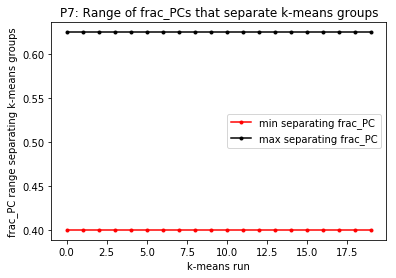

In [47]:
plt.figure()
plt.plot(np.arange(len(p7_km_seeds)),p7_min_PC_sep_range,color='r',label='min separating frac_PC',marker='.')
plt.plot(np.arange(len(p7_km_seeds)),p7_max_PC_sep_range,color='k',label='max separating frac_PC',marker='.')
plt.xlabel('k-means run')
plt.ylabel('frac_PC range separating k-means groups')
plt.title('P7: Range of frac_PCs that separate k-means groups')
plt.legend()
plt.show()

Check the number of unique groups

In [48]:
p7_all_id_groups = p7_g1_ids + p7_g2_ids
p7_u_groups = []
for list_curr in p7_all_id_groups:
    if list_curr not in p7_u_groups:
        p7_u_groups.append(list_curr) 
print(len(p7_u_groups))

2


***

Visualize the groupings by k-means

In [49]:
p7_km_ll = np.min(list(set(p7_min_PC_sep_range)))
p7_km_ul = np.max(list(set(p7_max_PC_sep_range)))
print(p7_km_ll)
print(p7_km_ul)

0.4
0.625


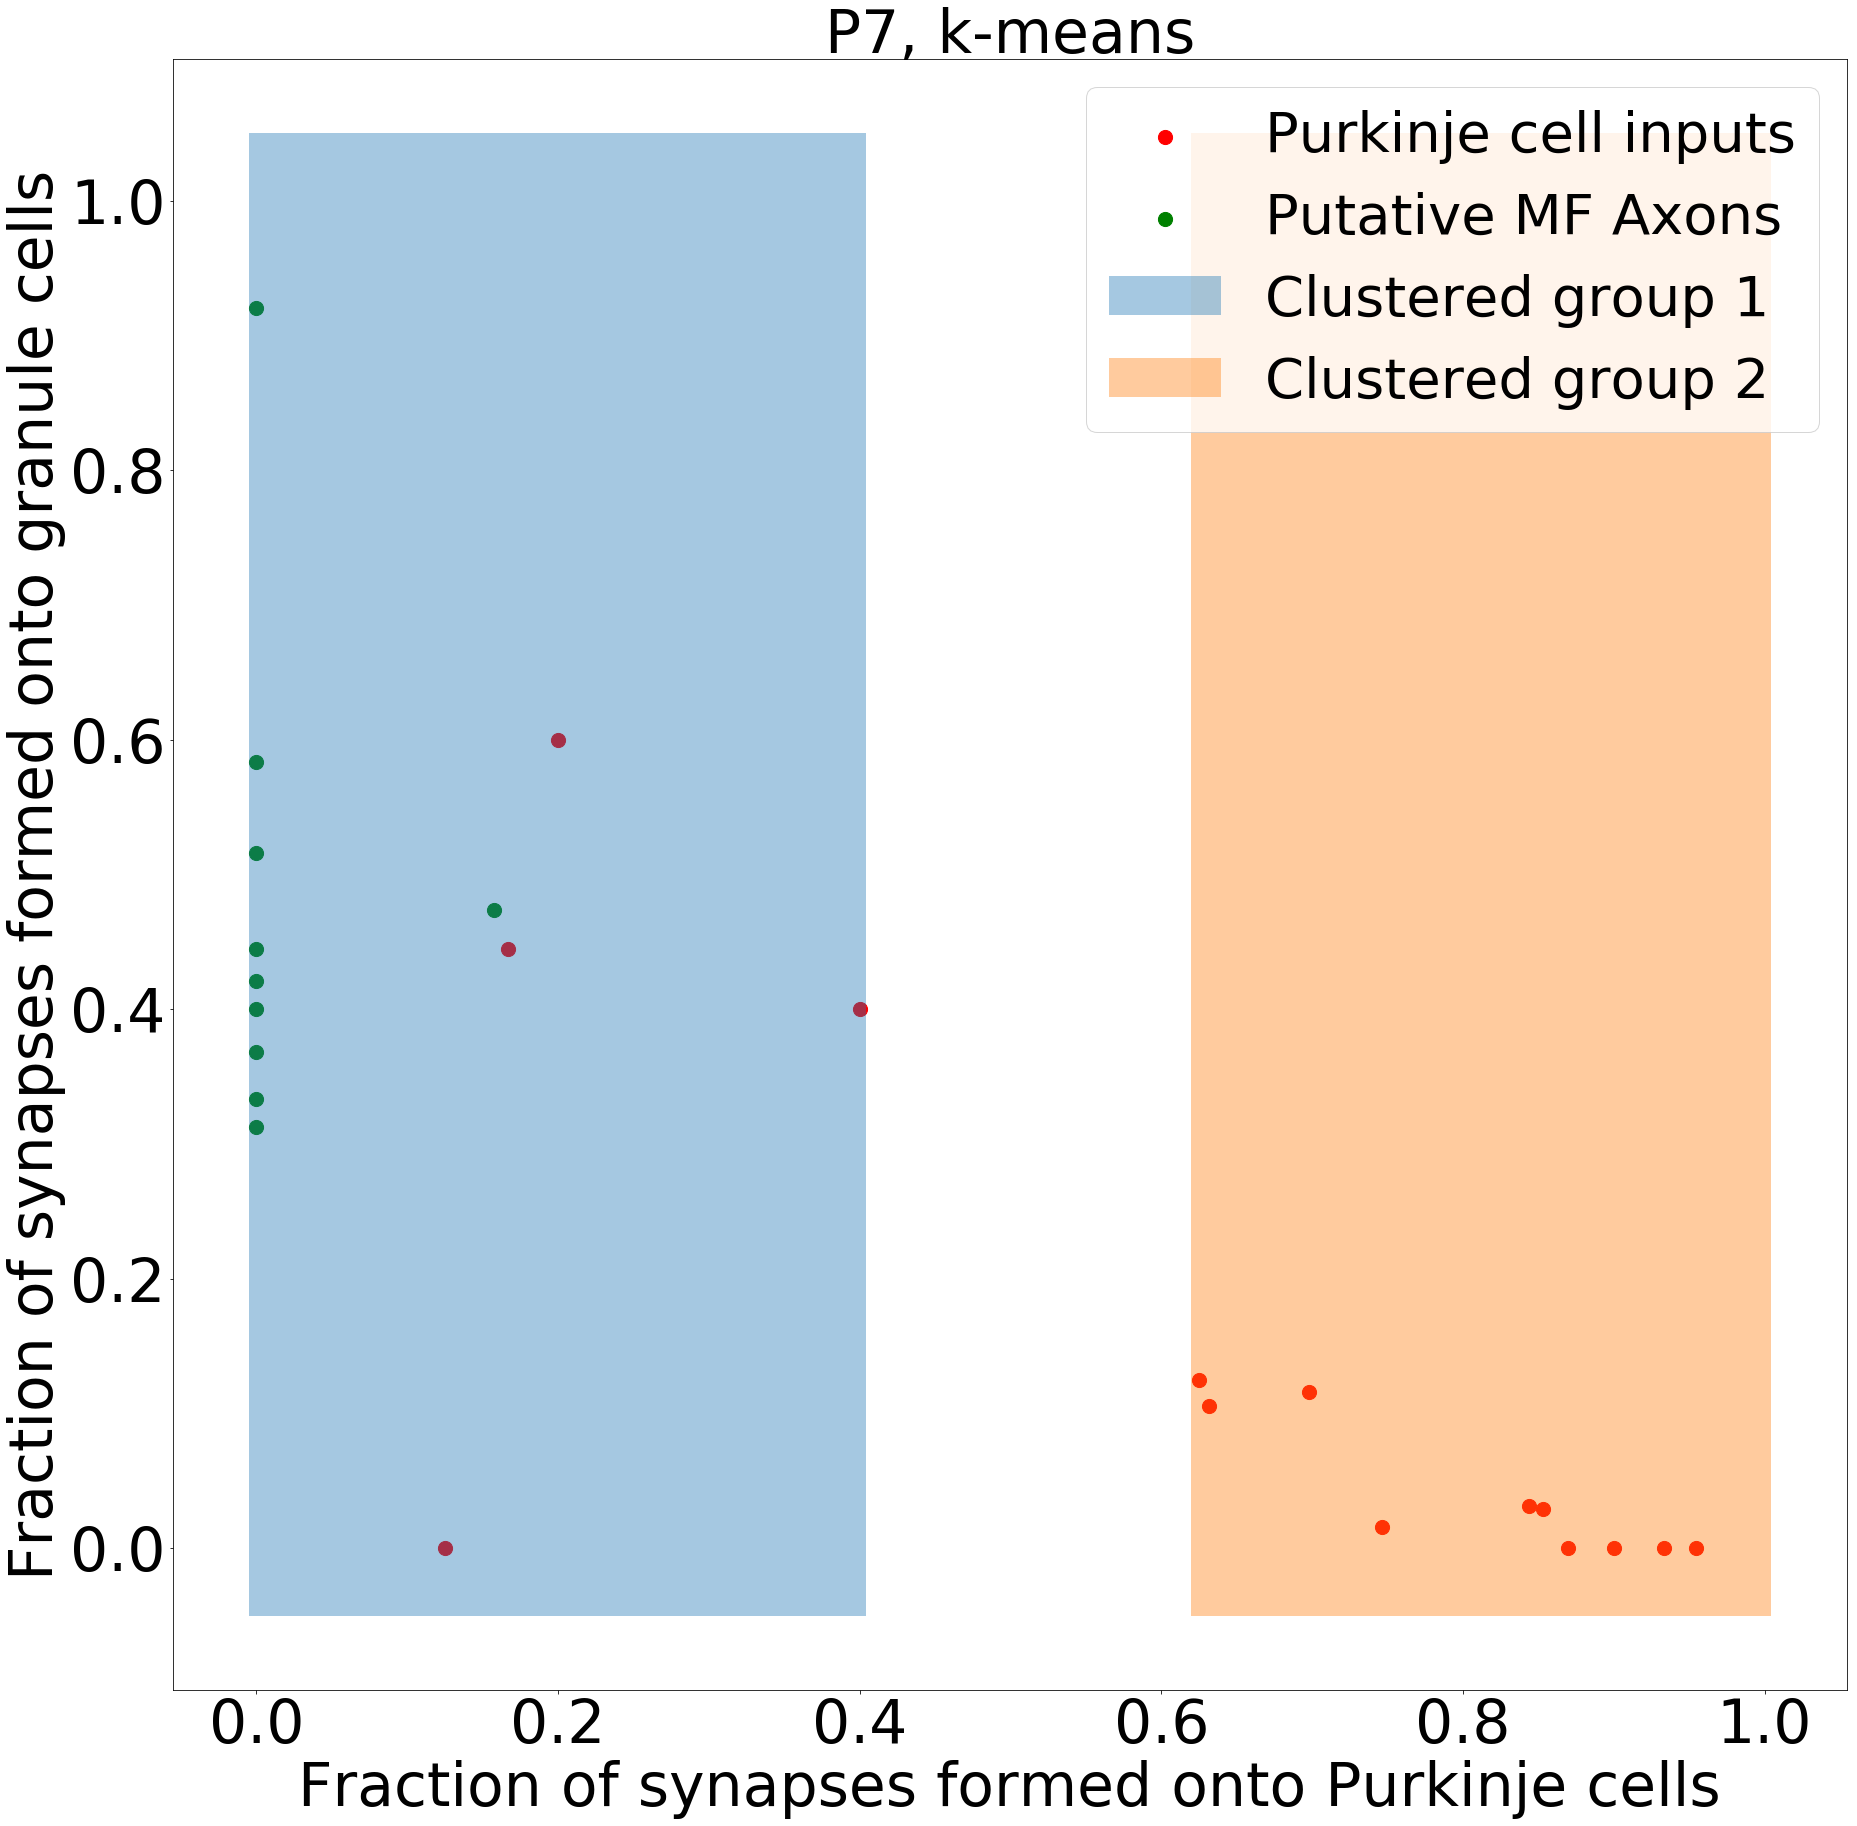

In [50]:
# p7, k-means partitioning
p7_km_ll = np.min(list(set(p7_min_PC_sep_range)))
p7_km_ul = np.max(list(set(p7_max_PC_sep_range)))

plt.figure(figsize=(30,30))
all_pc_input_pc_fracs = list(p7_hpc['n_PC_syns']/p7_hpc_tot_syns) + list(p7_lpc['n_PC_syns']/p7_lpc_tot_syns)
all_pc_input_gc_fracs = list(p7_hpc['n_GC_syns']/p7_hpc_tot_syns) + list(p7_lpc['n_GC_syns']/p7_lpc_tot_syns)
plt.scatter(all_pc_input_pc_fracs,all_pc_input_gc_fracs,s=MS,color='r',label='Purkinje cell inputs')
# plt.scatter(p7_hpc['n_PC_syns']/p7_hpc_tot_syns,p7_hpc['n_GC_syns']/p7_hpc_tot_syns,color='r',s=100,label='High-PC-Frac Seed Inputs')
# plt.scatter(p7_lpc['n_PC_syns']/p7_lpc_tot_syns,p7_lpc['n_GC_syns']/p7_lpc_tot_syns,color='b',s=100,label='Low-PC-Frac Seed Inputs')
plt.scatter(p7_putmf['n_PC_syns']/p7_putmf_tot_syns,p7_putmf['n_GC_syns']/p7_putmf_tot_syns,color='g',s=MS,label='Putative MF Axons')
xs_region1 = np.arange(-5,int(p7_km_ll*1000+5))*0.001
y1sr1 = np.zeros((xs_region1.shape[0]))-0.05
y2sr1 = y1sr1 + 1.1
xs_region2 = np.arange(p7_km_ul*1000-5,1005)*0.001
y1sr2 = np.zeros((xs_region2.shape[0]))-0.05
y2sr2 = y1sr2 + 1.1
plt.fill_between(xs_region1,y1sr1,y2sr1,alpha=0.4,label='Clustered group 1')
plt.fill_between(xs_region2,y1sr2,y2sr2,alpha=0.4,label='Clustered group 2')
plt.xlabel('Fraction of synapses formed onto Purkinje cells',fontsize=FS)
plt.ylabel('Fraction of synapses formed onto granule cells',fontsize=FS)
plt.title('P7, k-means',fontsize=FS)
plt.tick_params(labelsize=FS)
plt.legend(loc='best',fontsize=FS-4)
p7_km_fname = './data/figures/p3_p7_cf_mf_clustering/190218_p7_kmeans_clustering.png'
# plt.show()
plt.savefig(p7_km_fname)

***

### Hierarchical agglomerative clustering of P3 and P7 feature vectors

Note: there is nothing random about agglomerative clustering for a given dataset, so running this multiple times without employing something like k-fold cross-validation will make no difference in the groupings that come out of this process.

Start with single linkage agglomerative clustering, which minimizes the distance between closest observations of pairs of clusters when creating the clustering hierarchy

In [51]:
p3_agg_s_labels = AgglomerativeClustering(n_clusters = n_clust, linkage = 'single').fit_predict(p3_features)

In [52]:
p7_agg_s_labels = AgglomerativeClustering(n_clusters = n_clust, linkage = 'single').fit_predict(p7_features)

In [53]:
p3_agg_s_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [54]:
p7_agg_s_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

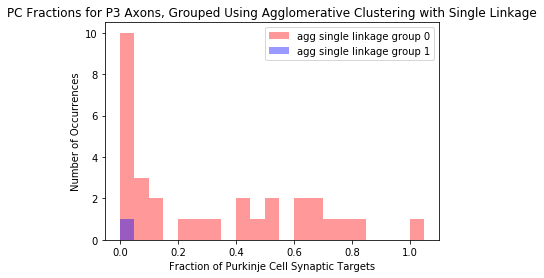

In [55]:
p3_agg_s_group0_locs = [i for i,q in enumerate(p3_agg_s_labels) if q==0]
p3_agg_s_group1_locs = [i for i,q in enumerate(p3_agg_s_labels) if q==1]

p3_agg_s_group0_pc_fracs = [p3_pc_fracs[i] for i in p3_agg_s_group0_locs]
p3_agg_s_group1_pc_fracs = [p3_pc_fracs[i] for i in p3_agg_s_group1_locs]

# You can re-calculate an appropriate bin size by using the maximum total
# number of synapses between an axon segment and all of its targets to see what the
# order of magnitude of the minimum synapse fraction will be.
# hist_bin_edges = 0.01 * np.arange(-5,105,10).astype(float)
hist_bin_edges = 0.01 * np.arange(0,110,5).astype(float)

plt.figure()
plt.hist(p3_agg_s_group0_pc_fracs,bins=hist_bin_edges,color='r',alpha=0.4,label='agg single linkage group 0')
plt.hist(p3_agg_s_group1_pc_fracs,bins=hist_bin_edges,color='b',alpha=0.4,label='agg single linkage group 1')
plt.xlabel('Fraction of Purkinje Cell Synaptic Targets')
plt.ylabel('Number of Occurrences')
plt.title('PC Fractions for P3 Axons, Grouped Using Agglomerative Clustering with Single Linkage')
plt.legend()
plt.show()

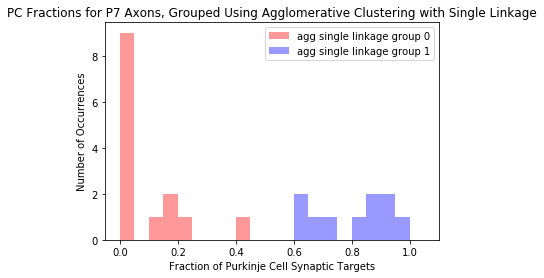

In [56]:
p7_agg_s_group0_locs = [i for i,q in enumerate(p7_agg_s_labels) if q==0]
p7_agg_s_group1_locs = [i for i,q in enumerate(p7_agg_s_labels) if q==1]

p7_agg_s_group0_pc_fracs = [p7_pc_fracs[i] for i in p7_agg_s_group0_locs]
p7_agg_s_group1_pc_fracs = [p7_pc_fracs[i] for i in p7_agg_s_group1_locs]

# You can re-calculate an appropriate bin size by using the maximum total
# number of synapses between an axon segment and all of its targets to see what the
# order of magnitude of the minimum synapse fraction will be.
# hist_bin_edges = 0.01 * np.arange(-5,105,10).astype(float)
hist_bin_edges = 0.01 * np.arange(0,110,5).astype(float)

plt.figure()
plt.hist(p7_agg_s_group0_pc_fracs,bins=hist_bin_edges,color='r',alpha=0.4,label='agg single linkage group 0')
plt.hist(p7_agg_s_group1_pc_fracs,bins=hist_bin_edges,color='b',alpha=0.4,label='agg single linkage group 1')
plt.xlabel('Fraction of Purkinje Cell Synaptic Targets')
plt.ylabel('Number of Occurrences')
plt.title('PC Fractions for P7 Axons, Grouped Using Agglomerative Clustering with Single Linkage')
plt.legend()
plt.show()

***

Now try agglomerative clustering with Ward linkage, which minimizes the sum of squared differences within all clusters.

In [57]:
p3_agg_w_labels = AgglomerativeClustering(n_clusters = n_clust, linkage = 'ward').fit_predict(p3_features)

In [58]:
p7_agg_w_labels = AgglomerativeClustering(n_clusters = n_clust, linkage = 'ward').fit_predict(p7_features)

In [59]:
p3_agg_w_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [60]:
p7_agg_w_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

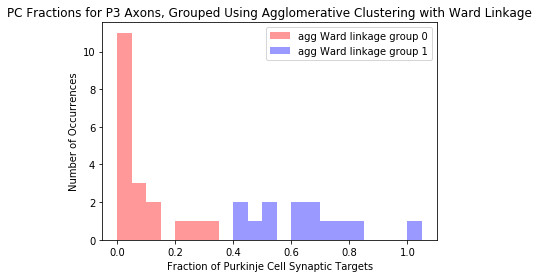

In [61]:
p3_agg_w_group0_locs = [i for i,q in enumerate(p3_agg_w_labels) if q==0]
p3_agg_w_group1_locs = [i for i,q in enumerate(p3_agg_w_labels) if q==1]

p3_agg_w_group0_pc_fracs = [p3_pc_fracs[i] for i in p3_agg_w_group0_locs]
p3_agg_w_group1_pc_fracs = [p3_pc_fracs[i] for i in p3_agg_w_group1_locs]

# You can re-calculate an appropriate bin size by using the maximum total
# number of synapses between an axon segment and all of its targets to see what the
# order of magnitude of the minimum synapse fraction will be.
# hist_bin_edges = 0.01 * np.arange(-5,105,10).astype(float)
hist_bin_edges = 0.01 * np.arange(0,110,5).astype(float)

plt.figure()
plt.hist(p3_agg_w_group0_pc_fracs,bins=hist_bin_edges,color='r',alpha=0.4,label='agg Ward linkage group 0')
plt.hist(p3_agg_w_group1_pc_fracs,bins=hist_bin_edges,color='b',alpha=0.4,label='agg Ward linkage group 1')
plt.xlabel('Fraction of Purkinje Cell Synaptic Targets')
plt.ylabel('Number of Occurrences')
plt.title('PC Fractions for P3 Axons, Grouped Using Agglomerative Clustering with Ward Linkage')
plt.legend()
plt.show()

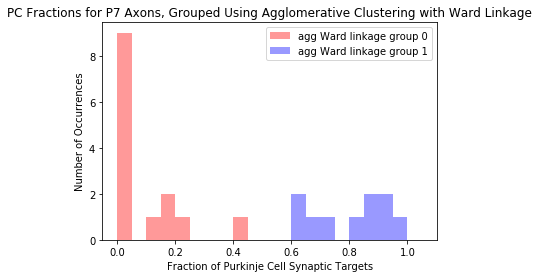

In [62]:
p7_agg_w_group0_locs = [i for i,q in enumerate(p7_agg_w_labels) if q==0]
p7_agg_w_group1_locs = [i for i,q in enumerate(p7_agg_w_labels) if q==1]

p7_agg_w_group0_pc_fracs = [p7_pc_fracs[i] for i in p7_agg_w_group0_locs]
p7_agg_w_group1_pc_fracs = [p7_pc_fracs[i] for i in p7_agg_w_group1_locs]

# You can re-calculate an appropriate bin size by using the maximum total
# number of synapses between an axon segment and all of its targets to see what the
# order of magnitude of the minimum synapse fraction will be.
# hist_bin_edges = 0.01 * np.arange(-5,105,10).astype(float)
hist_bin_edges = 0.01 * np.arange(0,110,5).astype(float)

plt.figure()
plt.hist(p7_agg_w_group0_pc_fracs,bins=hist_bin_edges,color='r',alpha=0.4,label='agg Ward linkage group 0')
plt.hist(p7_agg_w_group1_pc_fracs,bins=hist_bin_edges,color='b',alpha=0.4,label='agg Ward linkage group 1')
plt.xlabel('Fraction of Purkinje Cell Synaptic Targets')
plt.ylabel('Number of Occurrences')
plt.title('PC Fractions for P7 Axons, Grouped Using Agglomerative Clustering with Ward Linkage')
plt.legend()
plt.show()

***

### Compare the labels for the two groups produced using agglomerative clustering with the two groups produced using k-means clustering

In [63]:
p3_agg_w_group0_ids = [p3_obs_ids[i] for i in p3_agg_w_group0_locs]
p3_agg_w_group1_ids = [p3_obs_ids[i] for i in p3_agg_w_group1_locs]

p3_agg_w_groups = [p3_agg_w_group0_ids] + [p3_agg_w_group1_ids]

p7_agg_w_group0_ids = [p7_obs_ids[i] for i in p7_agg_w_group0_locs]
p7_agg_w_group1_ids = [p7_obs_ids[i] for i in p7_agg_w_group1_locs]

p7_agg_w_groups = [p7_agg_w_group0_ids] + [p7_agg_w_group1_ids]

Compare the P3 and P7 k-means unique groups with the P3 and P7 agglomerative clustering with Ward linkage groups

In [64]:
print(p3_u_groups)
print(p7_u_groups)

[[59, 176, 305, 357, 358, 365, 324, 325, 327, 322, 355, 402, 522, 521, 511, 461, 321, 328], [26, 42, 62, 71, 82, 105, 145, 151, 255, 265, 60, 288, 302, 346]]
[[25, 26, 35, 53, 71, 72, 73, 75, 591, 311, 361, 371, 381, 431], [40, 32, 55, 49, 61, 24, 15, 21, 10, 67]]


In [65]:
print(p3_agg_w_groups)
print(p7_agg_w_groups)

[[59, 176, 305, 346, 357, 358, 365, 324, 325, 327, 322, 355, 402, 522, 521, 511, 461, 321, 328], [26, 42, 62, 71, 82, 105, 145, 151, 255, 265, 60, 288, 302]]
[[25, 26, 35, 53, 71, 72, 73, 75, 591, 311, 361, 371, 381, 431], [40, 32, 55, 49, 61, 24, 15, 21, 10, 67]]


In [66]:
p3_km_aggw_groups = p3_u_groups + p3_agg_w_groups
p7_km_aggw_groups = p7_u_groups + p7_agg_w_groups

In [67]:
print(p3_km_aggw_groups)
print('\n')
print(p7_km_aggw_groups)

[[59, 176, 305, 357, 358, 365, 324, 325, 327, 322, 355, 402, 522, 521, 511, 461, 321, 328], [26, 42, 62, 71, 82, 105, 145, 151, 255, 265, 60, 288, 302, 346], [59, 176, 305, 346, 357, 358, 365, 324, 325, 327, 322, 355, 402, 522, 521, 511, 461, 321, 328], [26, 42, 62, 71, 82, 105, 145, 151, 255, 265, 60, 288, 302]]


[[25, 26, 35, 53, 71, 72, 73, 75, 591, 311, 361, 371, 381, 431], [40, 32, 55, 49, 61, 24, 15, 21, 10, 67], [25, 26, 35, 53, 71, 72, 73, 75, 591, 311, 361, 371, 381, 431], [40, 32, 55, 49, 61, 24, 15, 21, 10, 67]]


In [68]:
p3_km_aggw_u_groups = []
for list_curr in p3_km_aggw_groups:
    if list_curr not in p3_km_aggw_u_groups:
        p3_km_aggw_u_groups.append(list_curr) 
print(len(p3_km_aggw_u_groups))

4


In [69]:
p7_km_aggw_u_groups = []
for list_curr in p7_km_aggw_groups:
    if list_curr not in p7_km_aggw_u_groups:
        p7_km_aggw_u_groups.append(list_curr) 
print(len(p7_km_aggw_u_groups))

2


***

Take a look at the differences in the populations given in the agglomerated vs. k-means clustering of the P3 data. Or at least take note of the differences in the range of frac_PC values that separate the two groups at P3 in the two clustering methods

In [70]:
p3_agg_w_g1_min = np.min(p3_agg_w_group0_pc_fracs)
p3_agg_w_g1_max = np.max(p3_agg_w_group0_pc_fracs)
p3_agg_w_g2_min = np.min(p3_agg_w_group1_pc_fracs) 
p3_agg_w_g2_max = np.max(p3_agg_w_group1_pc_fracs)

# print(p3_agg_w_g1_min,p3_agg_w_g1_max,p3_agg_w_g2_min,p3_agg_w_g2_max)

print('Range of frac_PCs that separate groups from agglomerative clustering with Ward linkage, P3 data:')
if(p3_agg_w_g1_max < p3_agg_w_g2_min):
    p3_agg_ll = p3_agg_w_g1_max
    p3_agg_ul = p3_agg_w_g2_min
    print('[{0},{1}]'.format(p3_agg_w_g1_max,p3_agg_w_g2_min))
elif(p3_agg_w_g2_max < p3_agg_w_g1_min):
    p3_agg_ll = p3_agg_w_g2_max
    p3_agg_ul = p3_agg_w_g1_min
    print('[{0},{1}]'.format(p3_agg_w_g2_max,p3_agg_w_g1_min))
else:
    print('Groups overlap')

Range of frac_PCs that separate groups from agglomerative clustering with Ward linkage, P3 data:
[0.3333333333333333,0.4117647058823529]


In [71]:
p7_agg_w_g1_min = np.min(p7_agg_w_group0_pc_fracs)
p7_agg_w_g1_max = np.max(p7_agg_w_group0_pc_fracs)
p7_agg_w_g2_min = np.min(p7_agg_w_group1_pc_fracs)
p7_agg_w_g2_max = np.max(p7_agg_w_group1_pc_fracs)

print('Range of frac_PCs that separate groups from agglomerative clustering with Ward linkage, P7 data:')
if(p7_agg_w_g1_max < p7_agg_w_g2_min):
    p7_agg_ll = p7_agg_w_g1_max
    p7_agg_ul = p7_agg_w_g2_min
    print('[{0},{1}]'.format(p7_agg_w_g1_max,p7_agg_w_g2_min))
elif(p7_agg_w_g2_max < p7_agg_w_g1_min):
    p7_agg_ll = p7_agg_w_g2_max
    p7_agg_ul = p7_agg_w_g1_min
    print('[{0},{1}]'.format(p7_agg_w_g2_max,p7_agg_w_g1_min))
else:
    print('Groups overlap')


Range of frac_PCs that separate groups from agglomerative clustering with Ward linkage, P7 data:
[0.4,0.625]


***

Visualize results of agglomerative clustering

In [72]:
p3_agg_ul

0.4117647058823529

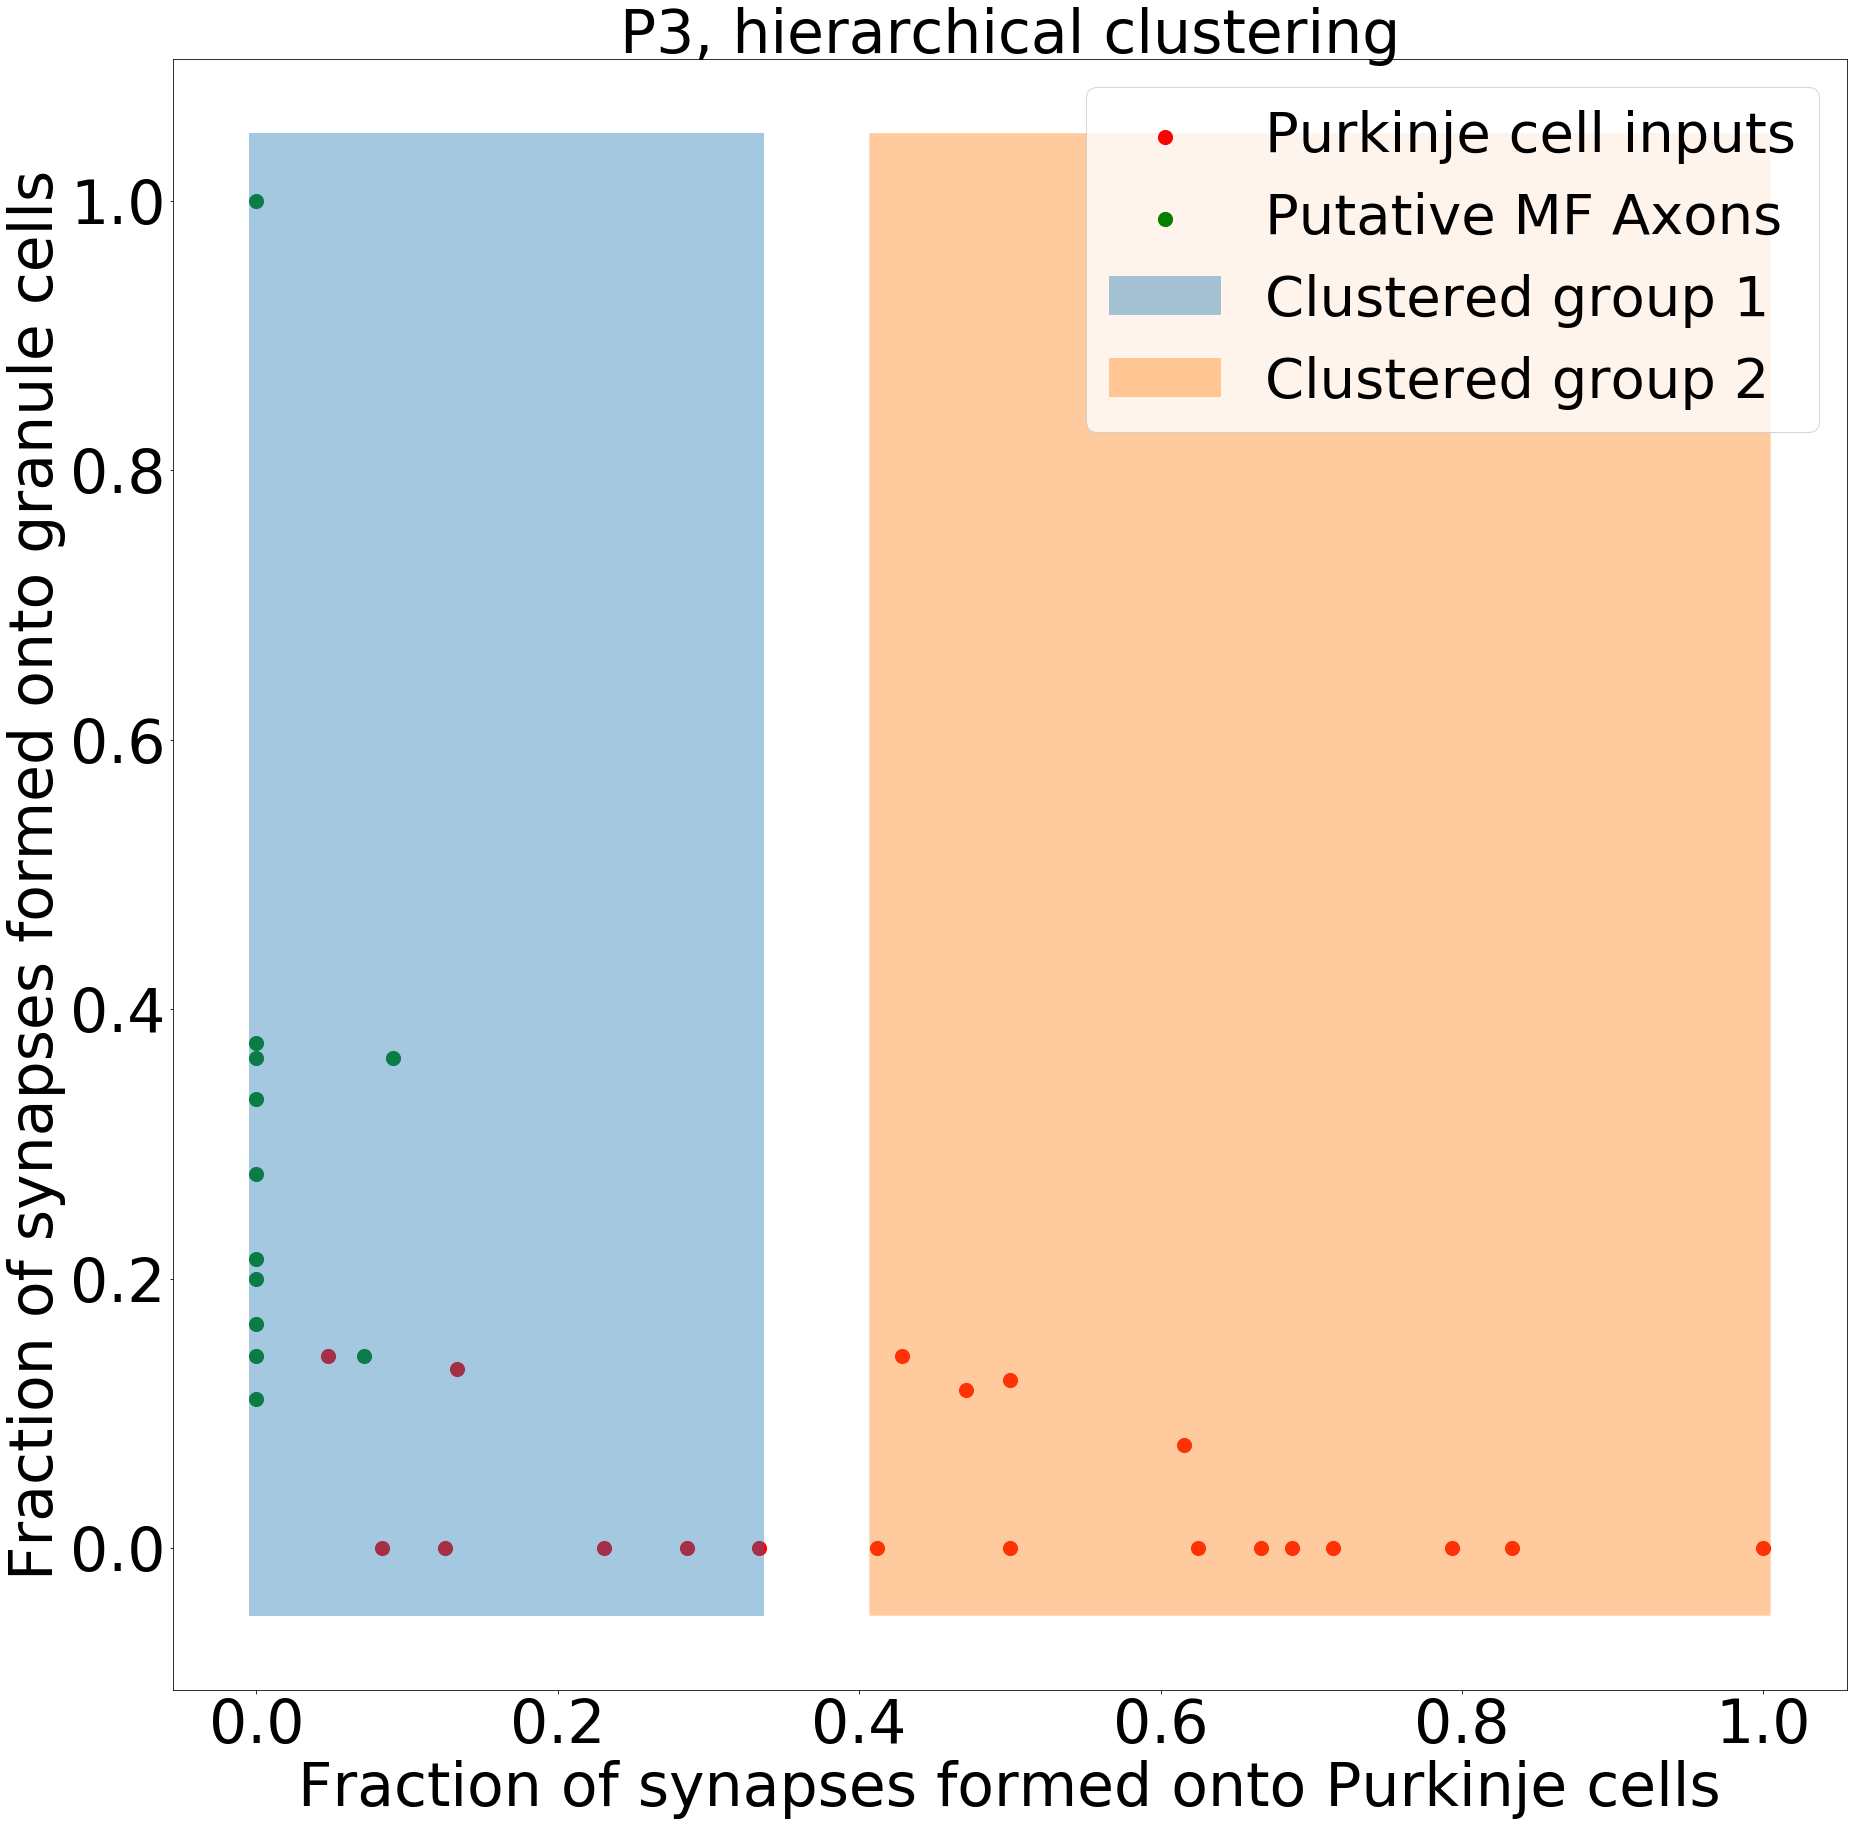

In [73]:
# p3, agglomerative clustering
plt.figure(figsize=(30,30))
all_pc_input_pc_fracs = list(p3_hpc['n_PC_syns']/p3_hpc_tot_syns) + list(p3_lpc['n_PC_syns']/p3_lpc_tot_syns)
all_pc_input_gc_fracs = list(p3_hpc['n_GC_syns']/p3_hpc_tot_syns) + list(p3_lpc['n_GC_syns']/p3_lpc_tot_syns)
plt.scatter(all_pc_input_pc_fracs,all_pc_input_gc_fracs,s=MS,color='r',label='Purkinje cell inputs')
# plt.scatter(p3_hpc['n_PC_syns']/p3_hpc_tot_syns,p3_hpc['n_GC_syns']/p3_hpc_tot_syns,color='r',s=100,label='High-PC-Frac Seed Inputs')
# plt.scatter(p3_lpc['n_PC_syns']/p3_lpc_tot_syns,p3_lpc['n_GC_syns']/p3_lpc_tot_syns,color='b',s=100,label='Low-PC-Frac Seed Inputs')
plt.scatter(p3_putmf['n_PC_syns']/p3_putmf_tot_syns,p3_putmf['n_GC_syns']/p3_putmf_tot_syns,color='g',s=MS,label='Putative MF Axons')
xs_region1 = np.arange(-5,int(p3_agg_ll*1000+5))*0.001
y1sr1 = np.zeros((xs_region1.shape[0]))-0.05
y2sr1 = y1sr1 + 1.1
xs_region2 = np.arange(p3_agg_ul*1000-5,1005)*0.001
y1sr2 = np.zeros((xs_region2.shape[0]))-0.05
y2sr2 = y1sr2 + 1.1
plt.fill_between(xs_region1,y1sr1,y2sr1,alpha=0.4,label='Clustered group 1')
plt.fill_between(xs_region2,y1sr2,y2sr2,alpha=0.4,label='Clustered group 2')
plt.xlabel('Fraction of synapses formed onto Purkinje cells',fontsize=FS)
plt.ylabel('Fraction of synapses formed onto granule cells',fontsize=FS)
plt.title('P3, hierarchical clustering',fontsize=FS)
plt.tick_params(labelsize=FS)
plt.legend(loc='best',fontsize=FS-4)
p3_agg_fname = './data/figures/p3_p7_cf_mf_clustering/190218_p3_agg_clustering.png'
# plt.show()
plt.savefig(p3_agg_fname)

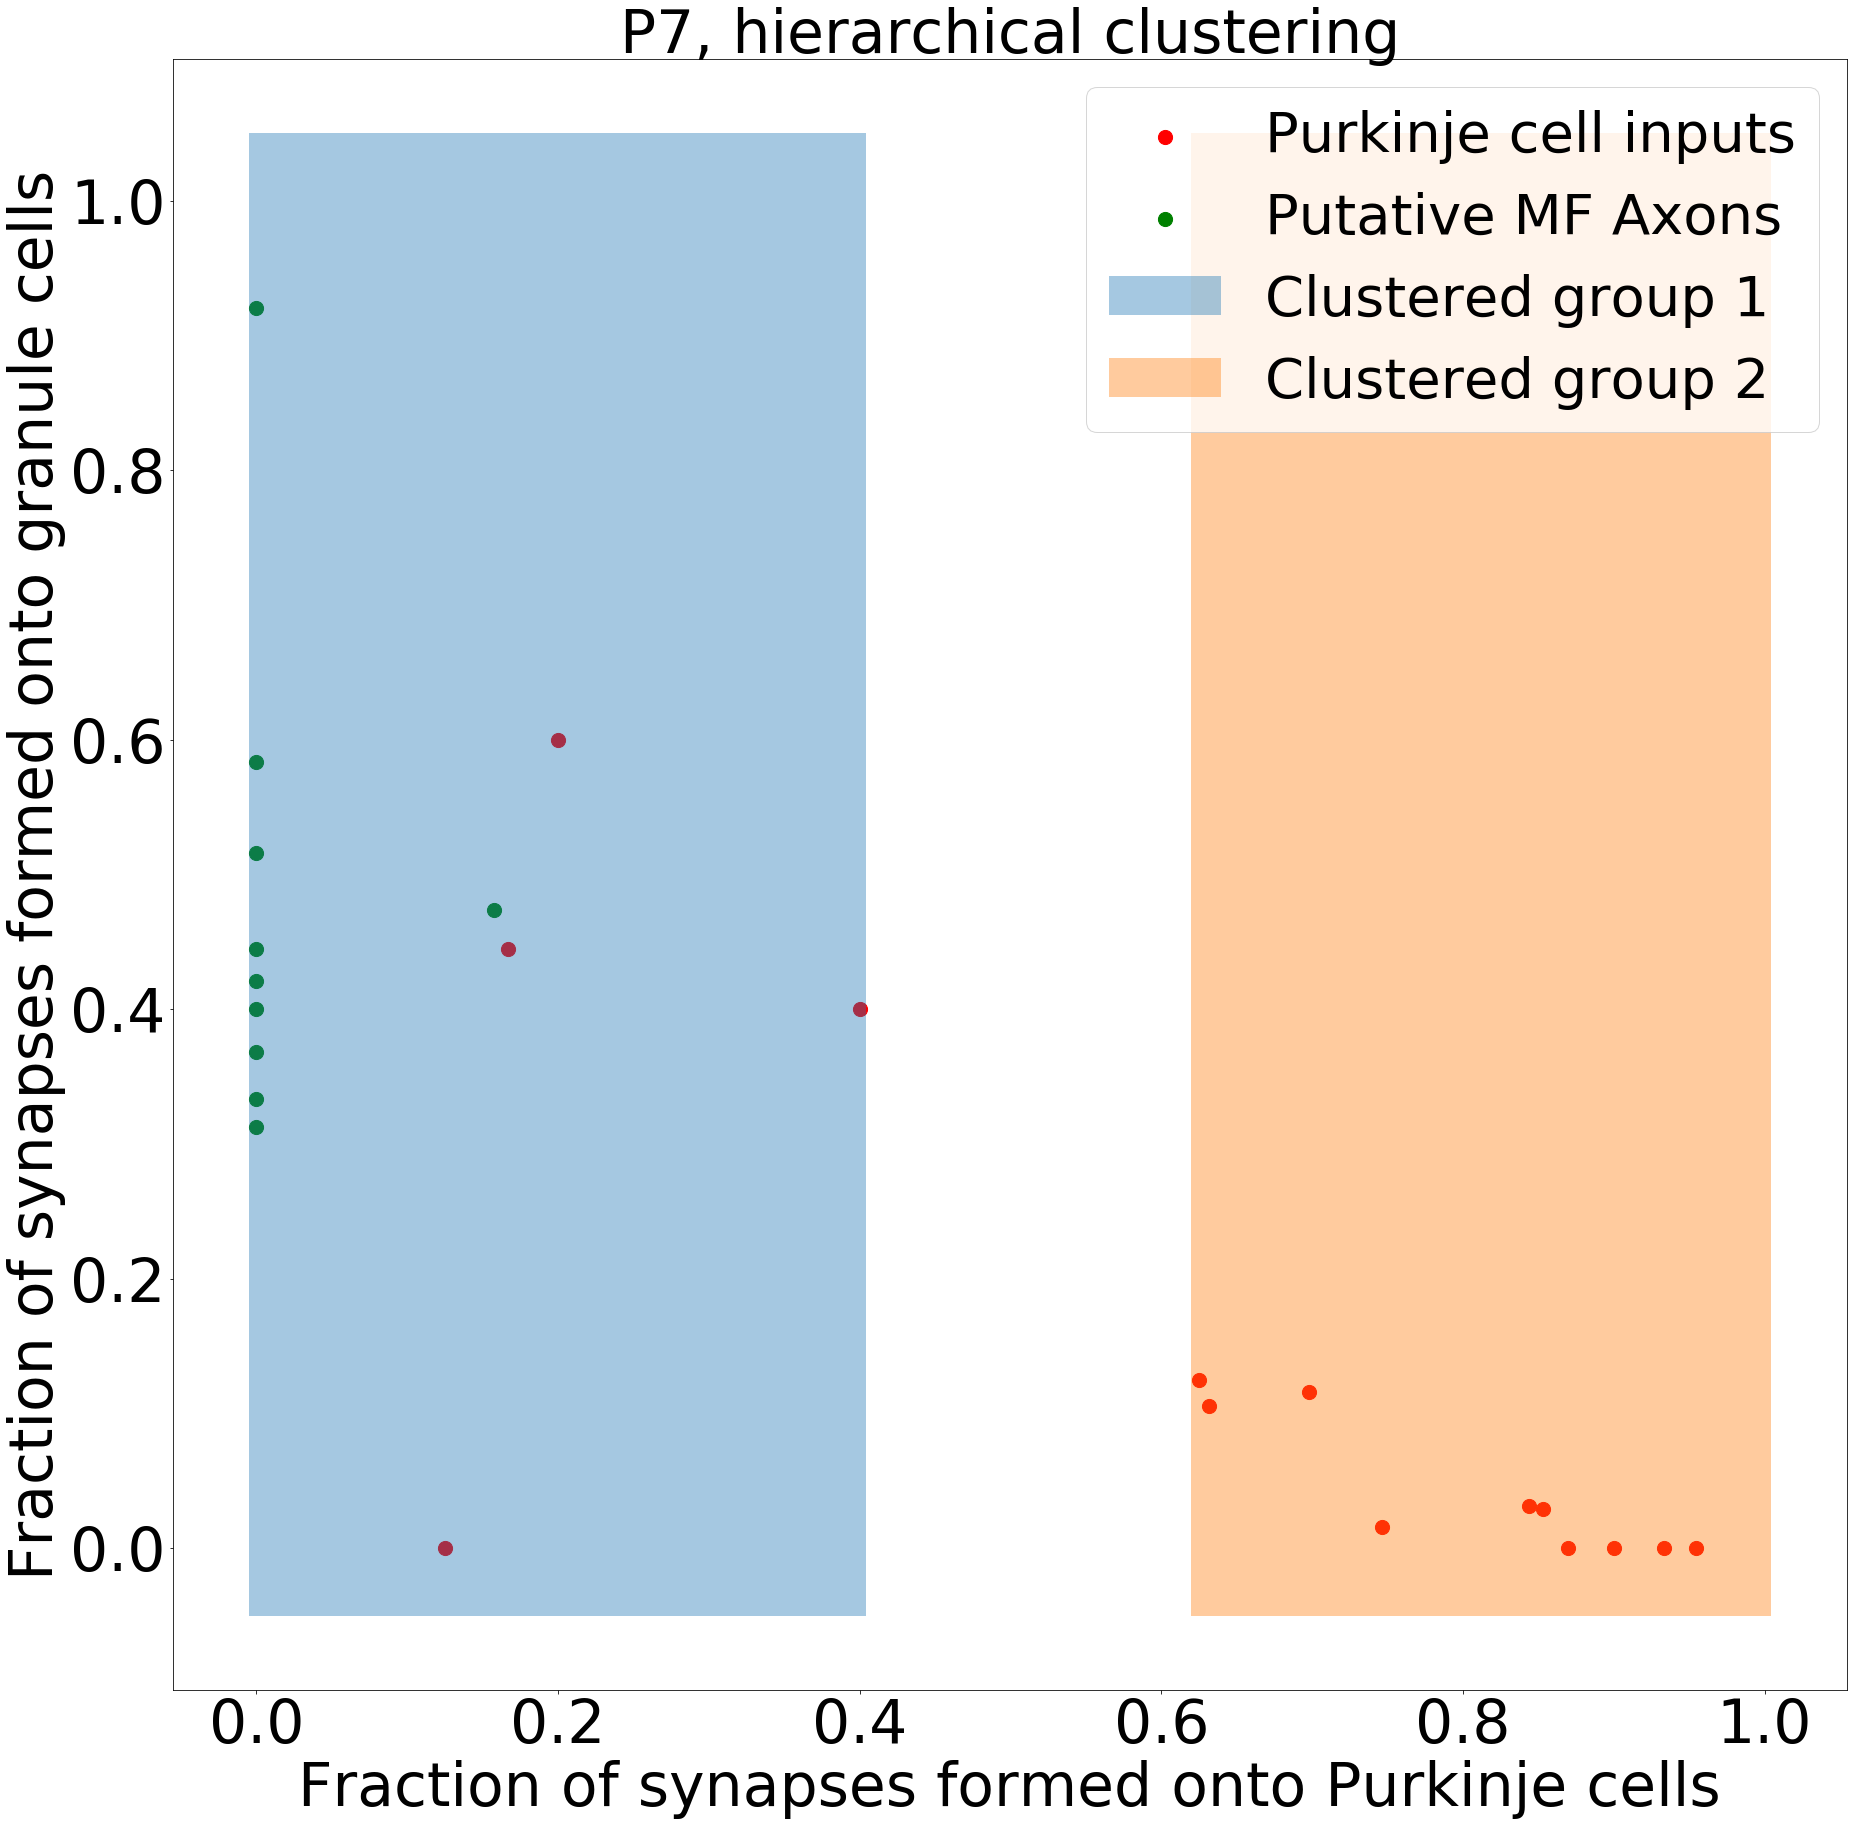

In [74]:
# p7, agglomerative clustering
plt.figure(figsize=(30,30))
all_pc_input_pc_fracs = list(p7_hpc['n_PC_syns']/p7_hpc_tot_syns) + list(p7_lpc['n_PC_syns']/p7_lpc_tot_syns)
all_pc_input_gc_fracs = list(p7_hpc['n_GC_syns']/p7_hpc_tot_syns) + list(p7_lpc['n_GC_syns']/p7_lpc_tot_syns)
plt.scatter(all_pc_input_pc_fracs,all_pc_input_gc_fracs,s=MS,color='r',label='Purkinje cell inputs')
# plt.scatter(p7_hpc['n_PC_syns']/p7_hpc_tot_syns,p7_hpc['n_GC_syns']/p7_hpc_tot_syns,color='r',s=100,label='High-PC-Frac Seed Inputs')
# plt.scatter(p7_lpc['n_PC_syns']/p7_lpc_tot_syns,p7_lpc['n_GC_syns']/p7_lpc_tot_syns,color='b',s=100,label='Low-PC-Frac Seed Inputs')
plt.scatter(p7_putmf['n_PC_syns']/p7_putmf_tot_syns,p7_putmf['n_GC_syns']/p7_putmf_tot_syns,color='g',s=MS,label='Putative MF Axons')
xs_region1 = np.arange(-5,int(p7_agg_ll*1000+5))*0.001
y1sr1 = np.zeros((xs_region1.shape[0]))-0.05
y2sr1 = y1sr1 + 1.1
xs_region2 = np.arange(p7_agg_ul*1000-5,1005)*0.001
y1sr2 = np.zeros((xs_region2.shape[0]))-0.05
y2sr2 = y1sr2 + 1.1
plt.fill_between(xs_region1,y1sr1,y2sr1,alpha=0.4,label='Clustered group 1')
plt.fill_between(xs_region2,y1sr2,y2sr2,alpha=0.4,label='Clustered group 2')
plt.xlabel('Fraction of synapses formed onto Purkinje cells',fontsize=FS)
plt.ylabel('Fraction of synapses formed onto granule cells',fontsize=FS)
plt.title('P7, hierarchical clustering',fontsize=FS)
plt.tick_params(labelsize=FS)
plt.legend(loc='best',fontsize=FS-4)
p7_agg_fname = './data/figures/p3_p7_cf_mf_clustering/190218_p7_agg_clustering.png'
# plt.show()
plt.savefig(p7_agg_fname)